# General Linear Model for Frequency and Severity

This notebooks leverages the dataset prepared in the `project-glm-eda.ipynb` notebook to build a Generalized Linear Model (GLM) for predicting insurance claim frequency and severity.  We will start by loading the data from a pickle file an evaluating it's structure.  For more information on how the dataset was prepared, please see the `project-glm-eda.ipynb` notebook.

## Safe Harbor Disclosure

This notebook is intended for educational purposes only.  The models and techniques presented herein are not intended for use in real-world insurance underwriting or pricing decisions.  Any resemblance to actual insurance products, policies, or practices is purely coincidental.  Users of this notebook should not rely on the models or techniques presented herein for any real-world applications without consulting a qualified insurance professional.

💥💥💥 In addition, it is important to note that files and directories referenced in the codebase may not exist in your local environment and may need to be created or modified to run the code successfully.  Please review the code and make any necessary adjustments to ensure compatibility with your local setup. 💥💥💥 

In [1]:
## Man, do I really need all these imports?
## Come back and check again in 42 years.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import display, Image, Markdown
from typing import Iterable, Optional
import os
from distfit import distfit
import scipy.optimize as optimize
import scipy.stats
from dask_ml.preprocessing import Categorizer
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_tweedie_deviance,
)
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_poisson_deviance
from glum import GeneralizedLinearRegressor
from glum import TweedieDistribution


# Reproducibility: set a global seed used by NumPy (helps when sampling / splitting later)
# Allows us to explore different binning strategies without changing the data used to
# fit the models
SEED_VAL = 42
np.random.seed(SEED_VAL)
TEST_SPLIT_SIZE = 0.2  # 20% test split

# Base paths for data and figures
# Note:  There still may be spots in the notebook where I use relative paths
#        therefore, you may run into errors if you run the notebook from
#        a different machine or directory.  Adjust accordingly.
SOURCE_DATA_PATH = "../data/source"
WORKING_DATA_PATH = "../data/working"
BINNING_DATA_PATH = f"../data/binning"
RESULTS_DATA_PATH = f"../data/results"
FIGURE_PATH = "../figures"

# Before We Begin

**DISCLOSURE**: Much of the code in this notebook is adapted from the `glum` [tutorial](https://glum.readthedocs.io/en/latest/tutorials/glm_french_motor_tutorial/glm_french_motor.html#) on insurance pricing.  I have modified it to fit my dataset and compare various binning and capping strategies, but the core concepts and methods are derived from this tutorial.

🔍 You will notice that the comments here are VERY robust.  This is intentional.  I used Perplexity to help me write detailed educational comments about my code because I was in study mode trying to learn the concepts and methods of GLM modeling.  I wanted to make sure I understood WHY we were doing what we were doing in each function.  I also leveraged GitHub Copilot to refactor code in a DRY fashion.  I am a software engineer and understand and influenced the AI assistant heavily in the implementation.  What I did NOT do is make this code into a full fledged Python package.  I do no want to build a wrapper around `glum`. I wanted to structure the code in a way that I could focus on the statistical modeling concepts for frequency and severity modeling.  This code is not production quality code.  It is educational code.  Please keep that in mind when reviewing it.

🧠 **Final Thoughts** 🧠
The purpose of the complexity here is to allow me to run many simulations and compare results.  For the submission of this assignment, I have drastically simplified the various model runs that I included.  I developed a dictionary structure that takes in a 1...n number of model configurations and runs them all in a loop.  This allows me to compare results across various binning and capping strategies.  In addition, the code can compare results across runs in summary tables.  It will also save the tables and visualizations to appropriate directories.  This is a lot of complexity compared to the base `glum` tutorial code, but the development of these modules and the DRY practices I applied helped me learn more about GLM modeling than I may have otherwise.  I hope you find it useful as well.

## Navigating This Notebook
This notebook has appropriate headings.  If you are working in Jupyter or VSCode, you can use the Table of Contents / Outline to navigate the notebook more easily.  When printed to PDF, the headings will also be included in the bookmarks for easier navigation.

# Let's Get Started

First thing's first, let's load the data.  I am not going to demo the underlying data here.  Please see the `project-glm-eda.ipynb` notebook for more information on the data and how it was prepared.

In [2]:
# Just to be safe, let's not let this workbook run unless the data file exists
# We want to make sure the dataset had the fields necessary for modeling
file_path = f"{WORKING_DATA_PATH}/final_features_complete.pkl"
if not os.path.exists(f"{file_path}"):
    raise FileNotFoundError(
        f"MUST run `project-glm-freq-sev-eda.ipynb` to generate input file."
    )
else:
    df = pd.read_pickle(f"{file_path}")
    # Dataset statistics will be surpressed here, but available
    # in appendix, copy df to facilitate just in case df changes
    df_appendix = df.copy()

    print(f"Loaded df_capped_unique with shape: {df.shape} from {file_path}")

Loaded df_capped_unique with shape: (678013, 39) from ../data/working/final_features_complete.pkl


# Helper Functions

To keep the notebook organized and avoid redundancy, we define several helper functions.  These functions follow DRY principles and allow us to easily switch between different configurations (e.g., predictor sets, model families) for both frequency and severity models without clobbering results.  We keep targets/weights, design matrices, and model families configurable and comparable.  Functions are at the top of the notebook because, well, they will be needed and I didn't want to break the flow of the notebook by interspersing them throughout.

Feel free to jump over this section to the [Frequency Modeling](#Frequency-Modeling) section if you want get right into the cool bits.

## Modeling Reusable Functions


In [3]:
def build_targets(df, task, *, claim_nb=None, exposure, claim_amt=None):
    """
    Build model-ready targets and weights specifically tuned to a classic insurance modeling question:
    Frequency (how often claims occur), Severity (how large those claims are), or Pure Premium (expected loss per exposure unit).

    This function forces the analyst to clarify which insurance dimension is being modeled.
    It ensures only rows with meaningful data for each task are used, and returns both targets and weights so model training is statistically sound.

    - 'frequency': builds targets and weights for predicting claim counts per exposure.
    - 'severity': isolates only those records where a loss occurred, building a target for average claim size and weighting each claim unit equally.
    - 'pure_premium': supports direct modeling of loss-per-exposure, a common metric for ratemaking, regardless of claim count column.

    Raises clear errors if the caller hasn't supplied enough information to define the problem unambiguously.
    """
    task = task.lower()

    # Frequency modeling asks: "How many claims do we expect for each policy?" (Classic Poisson/Negative Binomial setup.)
    # This branch structures targets as claim rates (claims divided by exposure), using exposures as sampling weights.
    if task == "frequency":
        if claim_nb is None:
            raise ValueError("frequency task requires 'claim_nb' column name")
        z = df[claim_nb].to_numpy(dtype=float)
        w = df[exposure].to_numpy(dtype=float)
        y = z / np.clip(w, 1e-12, None)
        idx = np.isfinite(y) & (w > 0)
        return {"y": y, "w": w, "z": z, "idx": idx}

    # Severity modeling focuses exclusively on policies that had (positive) claims with payouts.
    # The goal: estimate *average* claim size, so rate-making can be split into "how often?" and "how much?" components.
    elif task == "severity":
        if claim_amt is None or claim_nb is None:
            raise ValueError(
                "severity task requires both 'claim_nb' and 'claim_amt' column names"
            )
        z = df[claim_amt].to_numpy(dtype=float)
        n = df[claim_nb].to_numpy(dtype=float)
        idx = (n > 0) & (
            z > 0
        )  # Only model non-trivial claims with actual amounts paid.
        y = np.zeros_like(z, dtype=float)
        y[idx] = z[idx] / n[idx]
        w = n  # Each claim gets equal influence. This is crucial for unbiased severity estimates.
        return {"y": y, "w": w, "z": z, "idx": idx}

    # Pure premium is the all-in-one ratemaking target—directly modeling loss per unit exposure.
    # This is often the simplest route for premium setting, avoiding frequency/severity decomposition, but requires valid exposure and amount fields.
    elif task == "pure_premium":
        if claim_amt is None:
            raise ValueError("pure_premium task requires 'claim_amt' column name")
        amt = df[claim_amt].to_numpy(dtype=float)
        w = df[exposure].to_numpy(dtype=float)
        y = (amt / np.clip(w, 1e-12, None)).astype(float)
        idx = (w > 0) & np.isfinite(y)
        z = amt
        return {"y": y, "w": w, "z": z, "idx": idx}

    # If the user gave an unsupported task, fail with a clear message.
    else:
        raise ValueError("task must be 'frequency', 'severity', or 'pure_premium'")


def make_models(
    task,
    *,
    tweedie_powers: Iterable[float] = (1.3, 1.5, 1.7, 1.9),
    tweedie_alpha_search: bool = True,
    tweedie_l1_ratio: float = 1.0,
):
    """
    WHY: In insurance, model design should reflect the type of outcome being predicted—
    claim frequency, claim severity, or pure premium (loss per exposure unit).
    This function provides a unified, reproducible way to select suitable GLM-family models
    for each type of insurance target, ensuring consistency and repeatability in model comparison.

    - Frequency models address "how often" claims happen, the foundation of pricing and reserving.
    - Severity models address "how big" each claim will be, focusing modeling effort on explaining large-loss risk.
    - Pure premium models directly predict loss per exposure — an end-to-end alternative especially useful for ratemaking and benchmarking.

    By varying GLM model families and regularization techniques within each task, this function supports exploratory modeling and rigorous sensitivity analysis.
    """

    # Frequency: Model the number of claims/exposures with different count models.
    # - Poisson: Standard for count data; interpretable, but may struggle if variance > mean.
    # - Tweedie (p=1): Like Poisson, but can handle spikes at zero with more flexibility.
    # - Negative Binomial: Generalizes Poisson to allow extra variance, which is common in insurance claims.
    if task == "frequency":
        return {
            "Poisson GLM": GeneralizedLinearRegressor(
                family="poisson", alpha_search=True, l1_ratio=1.0, fit_intercept=True
            ),
            "Tweedie (freq)": GeneralizedLinearRegressor(
                family=TweedieDistribution(power=1.0),
                alpha=0.01,
                l1_ratio=0.0,
                fit_intercept=True,
            ),
            "Negative Binomial": GeneralizedLinearRegressor(
                family="negative.binomial",
                alpha=0.1,
                l1_ratio=0.0,
                fit_intercept=True,
                drop_first=True,
            ),
        }

    # Severity: Focuses on outcome size, for policies with positive claims.
    # - Gamma: Classic for continuous, positive, and right-skewed severity data.
    # - Tweedie (p=1.9): Flexible, interpolating between Gamma and inverse Gaussian; allows for highly skewed distributions.
    # - Gamma + ElasticNet: Applies regularization (ElasticNet) as a defense against overfitting and encourages sparse, interpretable models.
    elif task == "severity":
        return {
            "Gamma GLM": GeneralizedLinearRegressor(
                family="gamma", alpha_search=True, l1_ratio=1.0, fit_intercept=True
            ),
            "Tweedie p=1.9": GeneralizedLinearRegressor(
                family=TweedieDistribution(power=1.9),
                alpha=0.01,
                l1_ratio=0.0,
                fit_intercept=True,
            ),
            "Gamma + ElasticNet": GeneralizedLinearRegressor(
                family="gamma", alpha=0.01, l1_ratio=0.5, fit_intercept=True
            ),  # ElasticNet tested to encourage parsimony and handle highly correlated features.
        }

    # Pure premium: Direct modeling of loss per exposure, especially useful for practical pricing tasks or when frequency/severity decomposition is not preferred.
    # The Tweedie family is uniquely suited: it can model zero-inflated, continuous, and positive data in one framework.
    # This block efficiently sets up a grid of Tweedie models with varying power parameters, making sensitivity analysis easy.
    elif task == "pure_premium":
        models = {}
        for p in tweedie_powers:
            models[f"Tweedie (p={p:g})"] = GeneralizedLinearRegressor(
                family=TweedieDistribution(power=p),
                alpha_search=tweedie_alpha_search,
                l1_ratio=tweedie_l1_ratio,
                fit_intercept=True,
            )
        return models

    # Defensive: Forces modelers to specify a known insurance model type.
    else:
        raise ValueError("task must be 'frequency', 'severity', or 'pure_premium'")


def build_X(df, predictors, categoricals, itrain, itest):
    """
    Feature encoding spelled out here guarantees both train and test datasets experience the
    *same* transformation—crucial to avoid subtle data leakage and ensure that models see consistent inputs.
    This consistency builds trust that differences in model performance come from modeling choices, not data artifacts.
    """
    cat = Categorizer(columns=categoricals)
    X_tr = cat.fit_transform(df.loc[itrain, predictors])
    X_te = cat.transform(df.loc[itest, predictors])
    return X_tr, X_te, cat


def run_glm_experiment(
    df,
    *,
    task,
    pred_set_name,
    categoricals,
    numericals,
    split_seed=42,
    test_size=0.1,
    cols=None,
    pp_compare_power: float = 1.5,  # Reference deviance scale (Tweede power) for pure premium tasks
    tweedie_powers: Optional[
        Iterable[float]
    ] = None,  # Passing through to make_models for pure_premium grids
):
    """
    This function is the centerpiece of the modeling workflow:
    It manages the entire GLM experiment lifecycle from data preparation through fitting to evaluation.
    By wrapping all steps:
    - Target building with clear validity masks enforces task-specific data quality rules.
    - Train/test splits are carefully intersected with valid data masks to prevent leakage of bad data.
    - Encoding strategy is centralized and identical across splits.
    - Model family choices align with insurance modeling goals (frequency, severity, or pure premium).
    - A common deviance scale (p_compare) is selected per task to enable fair model comparison.
    - Results and coefficients summary give immediate insight and support further analyses.

    Parameters like pure-premium comparison power and Tweedie grids make this pipeline flexible for nuanced modeling
    scenarios, especially pure premium modeling that benefits from exploring different Tweedie power parameters.
        This design empowers analysts to run reproducible, configurable experiments that are suited to the three cornerstones of
    insurance pricing models: frequency, severity, and pure premium.

    """
    # Build task-specific targets, weights, and row validity mask to focus modeling on meaningful data.
    tgt = build_targets(df, task, **cols)
    y, w, mask = tgt["y"], tgt["w"], tgt["idx"]

    # Create a train/test split; masking with validity keeps only rows clean for the chosen task.
    ss = ShuffleSplit(n_splits=1, test_size=test_size, random_state=split_seed)
    tr_idx, te_idx = next(ss.split(df))
    itrain = np.zeros(len(df), dtype=bool)
    itrain[tr_idx] = True
    itrain &= mask
    itest = np.zeros(len(df), dtype=bool)
    itest[te_idx] = True
    itest &= mask

    # Assemble predictor columns and build encoded design matrices for model training & testing.
    predictors = list(categoricals) + list(numericals)
    X_tr, X_te, encoder = build_X(df, predictors, categoricals, itrain, itest)
    y_tr, y_te = y[itrain], y[itest]
    w_tr, w_te = w[itrain], w[itest]

    # Select models tailored to the insurance modeling task, supporting pure premium grids for tailored experimentation.
    models = make_models(task, tweedie_powers=(tweedie_powers or (1.3, 1.5, 1.7, 1.9)))

    # Define a common deviance comparison scale per task to enable apples-to-apples model scoring.
    if task == "frequency":
        p_compare = 1.0  # Poisson scale for count frequency models
    elif task == "severity":
        p_compare = 2.0  # Gamma-like scale for positive continuous severity models
    elif task == "pure_premium":
        p_compare = float(
            pp_compare_power
        )  # Tweedie power set for pure premium model grid
    else:
        raise ValueError(task)

    # Fit all selected models on training data. This batch fitting promotes consistency and efficiency.
    fitted = {
        name: mdl.fit(X_tr, y_tr, sample_weight=w_tr) for name, mdl in models.items()
    }

    # Compare model performances on train/test splits using the pre-defined deviance scale.
    # Provide summaries and coefficient comparisons for downstream interpretation.
    comp, details = compare_glms(
        fitted,
        X_tr,
        y_tr,
        w_tr,
        X_te,
        y_te,
        w_te,
        p_compare=p_compare,
        title=f"{task.replace('_',' ').title()} Model Comparison — [{pred_set_name}]",
    )
    tidy, wide_coef, wide_exp = compare_glm_coefficients(
        fitted, y_train=y_tr, w_train=w_tr, include_null=True
    )

    # Return a neatly structured dictionary containing everything a modeler needs to analyze, report, or feed into pipelines.
    return {
        "task": task,
        "pred_set": pred_set_name,
        "predictors": predictors,
        "categoricals": categoricals,
        "numericals": numericals,
        "encoder": encoder,
        "X_train": X_tr,
        "X_test": X_te,
        "y_train": y_tr,
        "y_test": y_te,
        "w_train": w_tr,
        "w_test": w_te,
        "split_train_idx": tr_idx,
        "split_test_idx": te_idx,
        "train_mask": itrain,
        "test_mask": itest,
        "models": fitted,
        "compare_table": comp,
        "model_details": details,
        "coef_tidy": tidy,
        "coef_wide": wide_coef,
        "coef_wide_exp": wide_exp,
        "p_compare": p_compare,
    }

## Model Metric Comparisons

- `compare_glms`: takes in the models and train/test data and prints out a summary of the model performance.  The format is a little nicer than the tutorial.

In [4]:
def _calibration_deciles(y, mu, w, q=10):
    """
    WHY:
    Calibration is a cornerstone of trustworthy insurance models. It tells us whether predicted losses
    match observed losses across the entire spectrum of risk, not just on average.

    This function diagnoses calibration by splitting data
    into bins (deciles by default) based on predicted values, then comparing observed vs. predicted
    averages within those bins. This reveals areas where the model may systematically under- or over-predict.

    We supplement this with a single RMSE number summarizing the deviation of the ratio Predicted/Observed (P/O) from perfect calibration (1.0).

    Inputs:
    - y: actual observed outcomes (claim counts, severity, or pure premium)
    - mu: model predictions for those outcomes
    - w: weights (e.g., exposures or claim counts) to account for differing data relevance
    - q: number of bins (deciles by default) to aggregate data for calibration checks

    The function tightly couples these elements to provide actionable calibration insight.
    """

    # We consolidate all inputs into a DataFrame for manipulation ease and synchronization of rows.
    # This structure allows sophisticated grouping and aggregation across bins.
    df = pd.DataFrame({"y": y, "mu": mu, "w": w})

    # Sanitize inputs by removing rows with missing or infinite values, preventing them from
    # distorting calibration metrics downstream.
    df = df[np.isfinite(df[["y", "mu", "w"]]).all(1)]

    # Divide predictions into quantile bins (deciles here).
    # This approach uniformly slices predicted risk into bins that help us inspect calibration of
    # both low- and high-risk policies separately, which is critical for nuanced pricing and reserving.
    df["dec"] = pd.qcut(df["mu"], q=min(q, df.shape[0]), duplicates="drop")

    # For each bin, calculate weighted averages of predicted and observed outcomes.
    # Weighting by exposures or claim counts respects the fact that not all data points carry equal importance.
    g = (
        df.groupby("dec", observed=False)
        .apply(
            lambda d: pd.Series(
                {
                    # What the model "thought" would happen on average in this bin — a reflection of risk predicted.
                    "pred_mean": np.average(d["mu"], weights=d["w"]),
                    # What actually happened, weighted to prevent small, unrepresentative subgroups from skewing results.
                    "obs_mean": np.average(d["y"], weights=d["w"]),
                    # Total weight gives a sense of how much information backs up each bin's stats.
                    "w": d["w"].sum(),
                }
            )
        )
        .reset_index(drop=True)
    )

    # Quantify calibration by comparing predicted to observed means per bin.
    # Values near 1 mean predictions and actuals track well, less or more than 1 indicates under- or over-prediction.
    g["P_over_O"] = g["pred_mean"] / g["obs_mean"]

    # To summarize overall calibration quality, compute root-mean-square error of P/O from 1.0.
    # This aggregates how far off predictions are on average, consolidating calibration into a single, interpretable number.
    rmse_po = np.sqrt(np.mean((g["P_over_O"] - 1.0) ** 2))

    # Return a detailed calibration table for in-depth inspection plus a summary metric for quick checks.
    return g, rmse_po


def score_glm(model, X_tr, y_tr, w_tr, X_te, y_te, w_te, p_compare=1.0, name=None):
    """
    This function is designed to provide a fair, apples-to-apples evaluation of any GLM-like model in an insurance context.
    WHY: Insurance models must be compared not just on fit, but on calibration, generalization, and improvement over a naive baseline.
    Compute comparable metrics for any GLM-like model.
    p_compare sets the deviance scale for fair model comparison:
      - Use p_compare=1.0 (Poisson) for frequency models (predicting claim counts),
        since Poisson deviance matches the distribution of count data.
      - Use p_compare=2.0 (Gamma-like) for severity models (predicting claim sizes),
        since Gamma deviance is suited for continuous, positive, and skewed outcomes.
    This ensures that all models are scored on a scale that reflects the real-world insurance problem at hand.

    """
    # Generate predictions for both train and test sets so we can assess not just fit, but also generalization (overfitting risk).
    mu_tr = model.predict(X_tr)
    mu_te = model.predict(X_te)

    # Use both the model's own deviance and a common deviance scale (Tweedie) to ensure that models with different families can be compared fairly.
    own = getattr(model, "family_instance", TweedieDistribution(p_compare))
    cmp = TweedieDistribution(p_compare)

    # Normalize deviance by total weights, so metrics are comparable across datasets of different sizes or exposure levels.
    wtr_sum = float(np.sum(w_tr))
    wte_sum = float(np.sum(w_te))

    # Compute mean deviance for both train and test, using both the model's own family and the common scale.
    # This dual approach helps us see if a model is well-calibrated to its own assumptions and also how it stacks up on a shared yardstick.
    md_tr_own = own.deviance(y_tr, mu_tr, sample_weight=w_tr) / wtr_sum
    md_te_own = own.deviance(y_te, mu_te, sample_weight=w_te) / wte_sum
    md_tr_cmp = cmp.deviance(y_tr, mu_tr, sample_weight=w_tr) / wtr_sum
    md_te_cmp = cmp.deviance(y_te, mu_te, sample_weight=w_te) / wte_sum

    # Establish a baseline: the null model predicts the (weighted) mean for everyone. This is the "do nothing" benchmark.
    # Improvement over this baseline tells us if the model is actually learning signal, not just noise.
    mu_null_te = np.full_like(y_te, np.average(y_tr, weights=w_tr), dtype=float)
    null_cmp = cmp.deviance(y_te, mu_null_te, sample_weight=w_te) / wte_sum
    improvement_pct = (null_cmp - md_te_cmp) / null_cmp * 100.0

    # Calibration is critical in insurance: does the model's risk stratification match reality across the spectrum?
    # This step checks calibration by decile and summarizes it with a P/O RMSE metric.
    cal_tbl, po_rmse = _calibration_deciles(y_te, mu_te, w_te)

    # Return a rich summary of model fit, generalization, calibration, and improvement over baseline, so modelers can make informed choices.
    return {
        "model": name or getattr(model, "name_", "model"),
        "family": getattr(
            model, "family", type(getattr(model, "family_instance", cmp)).__name__
        ),
        "#features": len(getattr(model, "feature_names_", [])),
        "intercept": float(getattr(model, "intercept_", np.nan)),
        "mean_dev_train_own": md_tr_own,
        "mean_dev_test_own": md_te_own,
        "mean_dev_train_compare": md_tr_cmp,
        "mean_dev_test_compare": md_te_cmp,
        "overfit_gap_compare": md_te_cmp - md_tr_cmp,
        "null_mean_dev_compare": null_cmp,
        "improvement_over_null_%": improvement_pct,
        "P/O_RMSE": po_rmse,
        "calibration_table": cal_tbl,
    }


def compare_glms(
    models: dict, X_tr, y_tr, w_tr, X_te, y_te, w_te, p_compare=1.0, title=None
):
    """
    WHY: In insurance modeling, it's not enough to fit a single model—you need to compare several candidates to find the best fit for your data and business goals.
    This function scores each model using a consistent deviance scale (set by p_compare), so results are directly comparable regardless of model family or outcome type.
    Key metrics like test deviance, improvement over a naive baseline, overfit gap, and calibration (P/O RMSE) are included to give a holistic view of model performance.

    For insurance analytics, model comparison is essential: it helps you select models that are not just accurate, but also reliable and interpretable for pricing, reserving, or risk segmentation.
    This function:
    - Scores each model on a common deviance scale, reflecting the statistical nature of your insurance target (frequency, severity, or pure premium).
    - Summarizes results in a tidy DataFrame, sorted by test deviance (lower is better), so you can quickly spot the best-performing models.
    - Provides detailed metrics for each model, supporting deeper analysis and regulatory reporting.
    """
    # Score each model using standardized metrics so you can compare them fairly, regardless of their statistical assumptions.
    rows, details = [], {}
    for name, mdl in models.items():
        m = score_glm(
            mdl, X_tr, y_tr, w_tr, X_te, y_te, w_te, p_compare=p_compare, name=name
        )
        details[name] = m
        rows.append(
            {
                "Model": m["model"],
                "Test Deviance": m["mean_dev_test_compare"],
                "Improvement %": m["improvement_over_null_%"],
                "Overfit Gap": m["overfit_gap_compare"],
                "P/O RMSE": m["P/O_RMSE"],
                "#Features": m["#features"],
            }
        )
    # Organize results into a DataFrame, sorted by test deviance, to make it easy to identify which models generalize best to new data.
    comp = pd.DataFrame(rows).sort_values("Test Deviance").reset_index(drop=True)

    # Optional: Print a formatted summary table for quick, visual comparison—especially useful in collaborative or regulatory settings.
    if title:
        print("\n" + "=" * 60)
        print(title.upper())
        print("=" * 60 + "\n")
        print(f"{'Model':<28} {'Test Deviance':>14} {'Improve %':>12} {'Overfit':>10}")
        print("-" * 68)
        for _, r in comp.iterrows():
            print(
                f"{r['Model']:<28} {r['Test Deviance']:>14.6f} {r['Improvement %']:>12.1f} {r['Overfit Gap']:>10.6f}"
            )
        print()

    # Return both the summary table and detailed metrics for further analysis, documentation, or audit.
    return comp, details

### Frequency x Severity Modeling Metrics

- `eval_severity_block`: evaluates a severity model on training and test data, returning various performance metrics.

In [5]:
def eval_severity_block(
    sev_model,
    X_tr_g,
    y_tr_g,
    w_tr_g,
    X_te_g,
    y_te_g,
    w_te_g,
    *,
    freq_model=None,
    X_tr_p=None,
    X_te_p=None,
    exposure_tr=None,
    exposure_te=None,
    claim_amt_tr=None,
    claim_amt_te=None,
    mu_tr_override=None,
    mu_te_override=None,
    label="Severity GLM",
    verbose=False,  # <- default quiet
):
    """
    WHY: In insurance, the pure premium (expected loss per exposure) is often modeled as the product of frequency (how often claims occur) and severity (how large claims are).
    This function evaluates both the severity model alone (on claims-only data) and the combined frequency × severity model (on all policies),
    allowing you to see how well different model pairings meet business objectives like accurate total loss prediction and reliable risk stratification.

    This function provides two layers of evaluation:
    1. **Pointwise severity metrics**: Focused on claims-only rows, it measures how well the severity model predicts individual claim sizes. This is crucial for understanding the model's ability to explain loss variability among claimants.
    2. **Two-part (frequency × severity) aggregates**: By combining frequency and severity predictions for all policies, it assesses how well the paired models estimate total portfolio losses—a key business metric for pricing and reserving.
    """
    Gamma = TweedieDistribution(2.0)

    # Pointwise evaluation: Only consider rows with claims, since severity is undefined for zero-claim policies.
    # This reveals how well the severity model explains the size of actual claims, independent of claim frequency.
    mu_tr_point = sev_model.predict(X_tr_g)
    mu_te_point = sev_model.predict(X_te_g)

    md_tr = Gamma.deviance(y_tr_g, mu_tr_point, sample_weight=w_tr_g) / np.sum(w_tr_g)
    md_te = Gamma.deviance(y_te_g, mu_te_point, sample_weight=w_te_g) / np.sum(w_te_g)

    wmae_tr = np.average(np.abs(y_tr_g - mu_tr_point), weights=w_tr_g)
    wmae_te = np.average(np.abs(y_te_g - mu_te_point), weights=w_te_g)

    ybar = np.average(y_tr_g, weights=w_tr_g)
    null_te = Gamma.deviance(
        y_te_g, np.full_like(y_te_g, ybar), sample_weight=w_te_g
    ) / np.sum(w_te_g)

    # Two-part evaluation: If frequency and severity models (and all required data) are provided, evaluate their combined ability to predict total losses for all policies.
    # This is the business-critical pure premium metric, showing how well the models work together for portfolio-level decision making.
    have_two_part = all(
        v is not None
        for v in (
            freq_model,
            X_tr_p,
            X_te_p,
            exposure_tr,
            exposure_te,
            claim_amt_tr,
            claim_amt_te,
        )
    )

    row = {
        "label": label,
        "sev_dev_train": md_tr,
        "sev_dev_test": md_te,
        "sev_wmae_train": wmae_tr,
        "sev_wmae_test": wmae_te,
        "sev_null_dev_test": null_te,
    }

    if have_two_part:
        # Predict claim rates (frequency) for all policies, not just those with claims.
        rate_tr = freq_model.predict(X_tr_p)
        rate_te = freq_model.predict(X_te_p)

        # Predict severity for all policies. If overrides are provided, use them to ensure alignment with the full portfolio.
        mu_tr_tot = mu_tr_override if mu_tr_override is not None else mu_tr_point
        mu_te_tot = mu_te_override if mu_te_override is not None else mu_te_point

        # Sanity check: Make sure severity predictions, exposures, and rates all align in length for valid aggregation.
        assert (
            len(mu_tr_tot) == len(exposure_tr) == len(rate_tr)
        ), "train shapes must match"
        assert (
            len(mu_te_tot) == len(exposure_te) == len(rate_te)
        ), "test shapes must match"

        # Compute aggregate predicted and observed totals for both train and test sets.
        pred_tr = float(np.sum(exposure_tr * rate_tr * mu_tr_tot))
        pred_te = float(np.sum(exposure_te * rate_te * mu_te_tot))
        obs_tr = float(np.sum(claim_amt_tr))
        obs_te = float(np.sum(claim_amt_te))

        # Compare predicted to observed totals using the P/O ratio, a key metric for portfolio-level calibration.
        row.update(
            {
                "po_train": pred_tr / max(obs_tr, 1e-12),
                "po_test": pred_te / max(obs_te, 1e-12),
                "pred_total_train": pred_tr,
                "obs_total_train": obs_tr,
                "pred_total_test": pred_te,
                "obs_total_test": obs_te,
            }
        )

    # Optional: Print detailed metrics for both pointwise and two-part evaluations, supporting transparency and business communication.
    if verbose:
        print(f"\n{label} — pointwise")
        print(f"deviance (train/test): {md_tr:.6f} / {md_te:.6f}")
        print(f"wMAE     (train/test): {wmae_tr:.1f} / {wmae_te:.1f}")
        print(f"null dev (test):       {null_te:.6f}")
        if have_two_part:
            print("two-part aggregates (Exposure × Freq × Sev):")
            print(
                f"train: pred={row['pred_total_train']:,.2f}  obs={row['obs_total_train']:,.2f}  P/O={row['po_train']:.3f}"
            )
            print(
                f"test : pred={row['pred_total_test']:,.2f}  obs={row['obs_total_test']:,.2f}  P/O={row['po_test']:.3f}"
            )

    # Return all relevant metrics for further analysis, reporting, or business review.
    return row


def run_two_part_grid(
    freq_runs, sev_runs, pairs, df, FREQ_SETS, SEV_SETS, verbose=False
):
    """
    This function is a powerhouse for insurance model evaluation, systematically comparing pairs of frequency and severity models to assess their combined performance on pure premium prediction.

    Why it's awesome:
    - It aligns train/test splits from severity runs to ensure predictions from frequency and severity models are perfectly synchronized, preventing data leakage and ensuring fair evaluation.
    - It builds frequency design matrices on the exact splits used by severity models, maintaining consistency across model inputs.
    - It cleverly fills in severity predictions for all policies, including those without claims, by using weighted averages for non-claim rows, enabling accurate portfolio-level loss estimation.
    - By calling `eval_severity_block`, it computes detailed metrics at both claim-level (severity) and portfolio-level (frequency × severity), providing a comprehensive view of model quality.
    - It compiles all results into a tidy, sortable DataFrame that highlights key metrics like deviance, weighted MAE, predicted/observed totals, and P/O ratios.
    - It adds intuitive flags to quickly identify model pairs that meet practical calibration thresholds, making it easy to spot strong candidates.
    - The detailed labeling of pairs and models supports transparency, traceability, and effective communication with stakeholders.

    In essence, this function transforms complex, multi-model evaluation into an accessible, business-focused summary that empowers actuaries and data scientists to make informed, data-driven decisions about their pure premium models.
    """
    rows = []
    for i, (freq_spec, sev_spec, pair_type, why) in enumerate(pairs, 1):
        # WHY: Pull the results of previously run frequency and severity experiments so we can pair up any combination for grid evaluation.
        fr = freq_runs[("frequency", freq_spec)]
        sr = sev_runs[("severity", sev_spec)]

        # WHY: For each pair, select the best (or specified) model from each experiment. This lets us test how different modeling choices interact when combined.
        freq_model_name = fr["compare_table"].iloc[0]["Model"]
        sev_model_name = sr["compare_table"].iloc[0]["Model"]
        freq_model = fr["models"][freq_model_name]
        sev_model = sr["models"][sev_model_name]

        # WHY: Use the severity run's train/test split to ensure both models are evaluated on the exact same data, preventing data leakage and ensuring fair, synchronized comparison.
        tr_idx = sr["split_train_idx"]
        te_idx = sr["split_test_idx"]

        # WHY: Re-encode frequency predictors on the same split as severity, so both models' predictions are aligned for every policy. This is essential for valid portfolio-level aggregation.
        X_tr_p = fr["encoder"].transform(df[fr["predictors"]].iloc[tr_idx])
        X_te_p = fr["encoder"].transform(df[fr["predictors"]].iloc[te_idx])

        # WHY: For pure premium, we need severity predictions for all policies, not just those with claims. We fill in non-claim rows with the weighted mean severity, so every policy has a plausible loss estimate.
        mu_tr_claims = sev_model.predict(sr["X_train"])
        mu_te_claims = sev_model.predict(sr["X_test"])
        mean_sev = np.average(sr["y_train"], weights=sr["w_train"])
        mu_tr_all = np.full(len(tr_idx), mean_sev)
        mu_te_all = np.full(len(te_idx), mean_sev)
        mu_tr_all[sr["train_mask"][tr_idx]] = mu_tr_claims
        mu_te_all[sr["test_mask"][te_idx]] = mu_te_claims

        # WHY: Identify the correct exposure and claim amount columns for this model pair, so we can aggregate predictions and observed losses accurately.
        expo_col = FREQ_SETS[freq_spec]["cols"]["exposure"]
        amt_col = SEV_SETS[sev_spec]["cols"]["claim_amt"]

        # WHY: Evaluate the combined frequency × severity model on both granular and aggregate metrics. This reveals not just how well each model works alone, but how well they work together for business-critical portfolio predictions.
        row = eval_severity_block(
            sev_model,
            X_tr_g=sr["X_train"],
            y_tr_g=sr["y_train"],
            w_tr_g=sr["w_train"],
            X_te_g=sr["X_test"],
            y_te_g=sr["y_test"],
            w_te_g=sr["w_test"],
            freq_model=freq_model,
            X_tr_p=X_tr_p,
            X_te_p=X_te_p,
            exposure_tr=df[expo_col].to_numpy()[tr_idx],
            exposure_te=df[expo_col].to_numpy()[te_idx],
            claim_amt_tr=df[amt_col].to_numpy()[tr_idx],
            claim_amt_te=df[amt_col].to_numpy()[te_idx],
            mu_tr_override=mu_tr_all,
            mu_te_override=mu_te_all,
            label=f"{pair_type.upper()}: {freq_spec} × {sev_spec} | F={freq_model_name}, S={sev_model_name}",
            verbose=verbose,
        )

        # WHY: Add metadata for traceability and easy filtering in the summary table.
        row.update(
            {
                "pair": f"{freq_spec} × {sev_spec}",
                "type": pair_type,
                "freq_model": freq_model_name,
                "sev_model": sev_model_name,
            }
        )
        rows.append(row)

    # WHY: Summarize all results in a single, tidy DataFrame so you can quickly compare all model pairs and spot the best-performing combinations for your business needs.
    out = (
        pd.DataFrame(rows)[
            [
                "pair",
                "type",
                "freq_model",
                "sev_model",
                "sev_dev_test",
                "sev_wmae_test",
                "sev_null_dev_test",
                "po_train",
                "po_test",
                "pred_total_train",
                "obs_total_train",
                "pred_total_test",
                "obs_total_test",
            ]
        ]
        .sort_values(["type", "po_test"])
        .reset_index(drop=True)
    )

    # WHY: Add clear, business-friendly flags to highlight model pairs that meet calibration targets (e.g., within 5% of observed totals), making it easy to spot candidates ready for production or further review.
    out["|P/O-1|% (test)"] = (out["po_test"].sub(1).abs() * 100).round(1)
    out["OK?"] = np.where(out["|P/O-1|% (test)"] <= 5, "✅", "⚠️")
    return out

### Tweedie Parameter Metrics


In [6]:
def summarize_pure_premium(pp_runs, spec=None):
    """
    WHY: In insurance, pure premium models directly predict expected loss per unit exposure (e.g., claim amount per policy-year). The Tweedie family is uniquely suited for this because it can flexibly model data with a mix of zeros and positive, skewed outcomes—just like real-world insurance losses.
    This function summarizes the performance of each pure premium model, focusing on two key aspects:
      1. Tweedie mean deviance (train/test): Measures how well the model fits the data on its own native scale, which is critical for fair comparison when models use different Tweedie powers.
      2. Portfolio totals (observed vs. predicted): Checks if the model's aggregate predictions align with actual losses, a business-critical metric for pricing and reserving.
    By reporting both, this function helps you spot models that are not only statistically sound but also business-relevant.

    Print Tweedie mean deviance (train/test) and portfolio totals for each PP model.
    Works directly on the outputs from run_glm_experiment(task='pure_premium').

    WHY: y = ClaimAmount / Exposure and weights = Exposure, so observed totals are ∑(w*y).
    """
    rows = []
    items = [k for k in pp_runs.keys() if k[0] == "pure_premium"]
    if spec is not None:
        items = [k for k in items if k[1] == spec]

    for key in items:
        res = pp_runs[key]
        spec_name = res["pred_set"]
        Xtr, Xte = res["X_train"], res["X_test"]
        ytr, yte = res["y_train"], res["y_test"]
        wtr, wte = res["w_train"], res["w_test"]

        # WHY: In pure premium modeling, the observed total loss is the sum of claim amounts weighted by exposure. This is the business target for pricing.
        obs_tr = float((wtr * ytr).sum())
        obs_te = float((wte * yte).sum())

        for mname, model in res["models"].items():
            # WHY: Score each model using its own Tweedie power, so the deviance reflects the model's assumptions and is comparable across models with different powers.
            Dist = getattr(
                model, "family_instance", TweedieDistribution(res.get("p_compare", 1.5))
            )
            mu_tr = model.predict(Xtr)
            mu_te = model.predict(Xte)

            # WHY: Mean deviance (train/test) is a principled way to measure model fit, accounting for both accuracy and the distributional shape of insurance losses.
            tr_loss = Dist.deviance(ytr, mu_tr, sample_weight=wtr) / wtr.sum()
            te_loss = Dist.deviance(yte, mu_te, sample_weight=wte) / wte.sum()

            # WHY: Aggregate predicted totals let you check if the model is "right for the right reason"—not just fitting the data, but also getting the business-critical totals correct.
            pred_tr = float((wtr * mu_tr).sum())
            pred_te = float((wte * mu_te).sum())

            rows.append(
                {
                    "Spec": spec_name,
                    "Model": mname,
                    "Power": getattr(Dist, "power", None),
                    "Train Dev": tr_loss,
                    "Test Dev": te_loss,
                    "Obs Total (train)": obs_tr,
                    "Pred Total (train)": pred_tr,
                    "Obs Total (test)": obs_te,
                    "Pred Total (test)": pred_te,
                }
            )

    out = pd.DataFrame(rows).sort_values(["Spec", "Test Dev"]).reset_index(drop=True)

    # WHY: Grouped printout makes it easy to compare models within each specification, highlighting which Tweedie power and model structure best balance fit and business realism.
    for spec_name, grp in out.groupby("Spec"):
        print("\n" + "=" * 60)
        print(f"PURE PREMIUM — {spec_name}")
        print("=" * 60)
        for _, r in grp.iterrows():
            print(f"\n{r['Model']} (p={r['Power']})")
            print(f"training loss (deviance): {r['Train Dev']:.6f}")
            print(f"testing  loss (deviance): {r['Test Dev']:.6f}")
            print(
                f"train totals  observed = {r['Obs Total (train)']:,.2f}, "
                f"predicted = {r['Pred Total (train)']:,.2f}"
            )
            print(
                f"test  totals  observed = {r['Obs Total (test)']:,.2f}, "
                f"predicted = {r['Pred Total (test)']:,.2f}"
            )

    return out


## Coefficient Comparisons

- `compare_glm_coefficients`: takes in a dictionary of models and they training and weight data and calculates and presents metrics related to model performance.
- `plot_model_coefficients`: takes in a dictionary of models and visually compares the coefficients of the models.

In [7]:
# Why this exists:
# - We want one source of truth to extract and compare coefficients across models.
# - Exponentiated coefficients (log-link) are easier to explain: they’re multiplicative factors.
# - A tidy format makes downstream analysis and plotting simple and consistent.


# Accepts partial / case-insensitive names like "Poisson" or "NegBinom".
def _resolve_model_name(requested, candidates):
    req = requested.strip().lower()
    # exact (case-insensitive)
    for c in candidates:
        if c.lower() == req:
            return c
    # partial
    matches = [c for c in candidates if req in c.lower()]
    if len(matches) == 1:
        return matches[0]
    raise ValueError(
        f"Model name '{requested}' not found. " f"Available: {sorted(candidates)}"
    )


def _union_features(models_dict):
    """Collect the union of all feature names across models (no intercept)."""
    feats = set()
    for m in models_dict.values():
        feats.update(getattr(m, "feature_names_", []))
    return sorted(feats)


def _model_coef_frame(model, name, all_features):
    """
    Create a tidy frame for one model over the full feature union.
    Missing features (e.g., dropped by regularization) are NaN to signal absence.
    """
    coef_map = dict(zip(model.feature_names_, model.coef_))
    data = {
        "model": name,
        "feature": ["(Intercept)"] + all_features,
        "coef": [float(getattr(model, "intercept_", np.nan))]
        + [coef_map.get(f, np.nan) for f in all_features],
    }
    df = pd.DataFrame(data)
    df["is_intercept"] = df["feature"].eq("(Intercept)")
    # For log links (Poisson/Gamma/Tweedie), exp(coef) is a multiplicative factor on the mean
    df["exp_coef"] = np.exp(df["coef"])
    return df


def compare_glm_coefficients(
    models_dict, y_train=None, w_train=None, include_null=True
):
    """
    Build a tidy coefficient table across models and (optionally) a Null pseudo-model.
    - Null intercept = log(weighted mean of y_train) under log-link; feature coefs are NaN.
    - Returns (tidy_df, wide_coef_df, wide_exp_df).
    """
    all_features = _union_features(models_dict)
    frames = []

    # --- Optional Null pseudo-model for interpretability ---
    if include_null and (y_train is not None) and (w_train is not None):
        # Why: the intercept for a log-link-only model is log(weighted mean of y),
        # which gives stakeholders a baseline to compare multiplicative factors against.
        null_intercept = float(np.log(np.average(y_train, weights=w_train)))

        nrows = 1 + len(all_features)  # (Intercept) + every feature row
        null = pd.DataFrame(
            {
                # Why: all columns must be same length; repeat "Null" for each row.
                "model": ["Null"] * nrows,
                "feature": ["(Intercept)"] + all_features,
                "coef": [null_intercept] + [np.nan] * len(all_features),
            }
        )
        null["is_intercept"] = null["feature"].eq("(Intercept)")
        null["exp_coef"] = np.exp(null["coef"])
        frames.append(null)

    # --- Actual models ---
    for name, model in models_dict.items():
        frames.append(_model_coef_frame(model, name, all_features))

    tidy = pd.concat(frames, ignore_index=True)

    # Wide (spreadsheet-style) views
    wide_coef = tidy.pivot(
        index="feature", columns="model", values="coef"
    ).reset_index()
    wide_exp = tidy.pivot(
        index="feature", columns="model", values="exp_coef"
    ).reset_index()

    return tidy, wide_coef, wide_exp


def top_features(tidy_df, model_name, n=20, by="abs"):
    """
    Get top-N features by |coef| (default) or by |exp_coef-1| for multiplicative effect size.
    Intercept is excluded; use this to narrate which features move the needle the most.
    """
    model_name = _resolve_model_name(model_name, tidy_df["model"].unique())
    df = tidy_df[
        (tidy_df["model"] == model_name) & (~tidy_df["feature"].eq("(Intercept)"))
    ].copy()
    if by == "abs":
        df["score"] = df["coef"].abs()
    elif by == "factor_delta":
        df["score"] = (df["exp_coef"] - 1.0).abs()
    else:
        raise ValueError("by must be 'abs' or 'factor_delta'")
    
    df = df.sort_values("score", ascending=False).head(n)[
            ["feature", "coef", "exp_coef", "score"]
        ]

    file_path=f"{RESULTS_DATA_PATH}/{model_name}_top_{n}_features.csv"
    if not os.path.exists(RESULTS_DATA_PATH):
        os.makedirs(RESULTS_DATA_PATH)
    df.to_csv(file_path, index=False)
    print(f"Saved top-{n} features to {file_path}")

    return df


def features_dropped(wide_coef_df, model_name):
    """
    List features that are NaN in a given model's coefficient column (i.e., not present after fitting).
    Useful for seeing what a penalized/Tweedie model removed.
    """
    model_name = _resolve_model_name(
        model_name, [c for c in wide_coef_df.columns if c != "feature"]
    )
    col = model_name
    dropped = wide_coef_df[
        (wide_coef_df["feature"] != "(Intercept)") 
         & (wide_coef_df[col].isna())]["feature"].tolist()

    file_path=f"{RESULTS_DATA_PATH}/{model_name}_dropped_features.csv"
    if not os.path.exists(RESULTS_DATA_PATH):
        os.makedirs(RESULTS_DATA_PATH)
    pd.DataFrame({"dropped_features": dropped}).to_csv(file_path, index=False)
    print(f"Saved dropped features to {file_path}")

    return dropped


def plot_model_coefficients(tidy_df, model_name, exp=False, top_n=None):
    """
    Educational plot for one model’s coefficients.
    - If exp=True, plot multiplicative factors (exp(coef)) to aid stakeholder explainability.
    - If top_n is set, show only the top-N by |coef|.
    """
    if exp:
        coef_type='multiplicative'
    else:
        coef_type='log-scale'

    model_name = _resolve_model_name(model_name, tidy_df["model"].unique())
    df = tidy_df[
        (tidy_df["model"] == model_name) & (~tidy_df["feature"].eq("(Intercept)"))
    ].copy()
    df["abs_coef"] = df["coef"].abs()
    if top_n:
        df = df.nlargest(top_n, "abs_coef")
    df = df.sort_values("coef")

    fig = plt.figure(figsize=(10, max(6, int(len(df) * 0.3))))
    x = df["exp_coef"] if exp else df["coef"]
    plt.barh(df["feature"], x)
    plt.axvline(x=1.0 if exp else 0.0, linestyle="--", linewidth=0.8)
    plt.xlabel("Factor (exp(coef))" if exp else "Coefficient (log scale)")
    plt.title(
        f"{model_name} Coefficients" + (" — multiplicative factors" if exp else "")
    )
    plt.tight_layout()
    save_name=model_name.replace(" ", "_").replace("/", "_")
    if not os.path.exists(f"{FIGURE_PATH}/results"):
        os.makedirs(f"{FIGURE_PATH}/results")
    fig.savefig(f"{FIGURE_PATH}/results/{save_name}_{coef_type}_coefs.png", dpi=300, bbox_inches='tight')
    print(f"Saved figure to {FIGURE_PATH}/results/{save_name}_{coef_type}_coefs.png")
    plt.show()

# Frequency GLM using `glum`  
[Take Me to the Code](#create-frequency-model-sets)

**Frequency Modeling** estimates **how many claims we expect per unit of exposure** (e.g., per policy-year).  
This step is the heartbeat of insurance pricing — we want to predict claim counts accurately enough to cover losses and expenses while staying competitive.

---

### ⚙️ The General Approach

- 🧮 We typically use a **Poisson GLM with a log link**.  
  If the data shows over-dispersion, we can upgrade to a **Negative Binomial** or **Tweedie** model.
  
- 🧭 To make coefficients reflect claim **rates** (not raw counts), include an **exposure offset**:

```python
  log(mu_i) = X_i · beta + log(Exposure_i)
````

This keeps interpretations intuitive — each coefficient shows how that variable affects claim rate, holding exposure constant.

* 🔁 You can also think of it as modeling `ClaimNb / Exposure` with `weights = Exposure`.
  Same math, different view — both roads lead to Rome.

* 🧩 If certain predictors get a little noisy, consider **elastic-net regularization**.
  It adds a gentle nudge toward stability without making the model mysterious or overly “black box.”

---

### 🧠 Measuring Performance

For model comparisons, focus on **Deviance**, **Mean Absolute Error**, and **P/O Ratios** — they’ll tell you how your models rank on fit and parsimony.
Once the stats check out, move on to **coefficient plots** to explore *why* certain features drive claim frequency up or down.

That’s where the actuarial storytelling begins.

## Create Frequency Model Sets

Here, we create several different frequency model sets to compare. Each set uses a different combination of predictors, binning, and capping strategies.

**Key Configuration Feature**: Each spec includes a dictionary that specifies which predictor and target columns to use. This allows predictor transformations (capped, binned, raw) to align with corresponding target definitions:

- **`categoricals`** and **`numericals`**: Feature lists for this model variant
- **`cols`**: Target column specifications
  - `claim_nb`: Claim count column ("ClaimNb" for raw, "ClaimNb_capped" for capped)
  - `exposure`: Exposure column ("Exposure" for raw, "Exposure_capped" for capped)
  - `claim_amt`: Claim amount column ("ClaimAmount" for raw, "ClaimAmount_capped" for capped)

This structure ensures that when we use capped predictors, we can also use capped targets for consistent modeling assumptions. Setting up this dictionary allows us to easily loop through and compare the results of each model set without clobbering results from previous runs.

### Explaining our Model Configurations

In our configuration, we define the model names (`glum_baseline`, `manual_bin_glum_tgt`).  The categorical and numerical predictors are defined for each model.  To ensure that we are comparing apples to apples, we define the same targets for each model.  Because I wanted to use the glum tutorials metrics as a home base for comparison, I used the target variables that matched the tutorials transformed dataset.  The primary differences between the models predictors are in the fact that the manual bin model uses the manually binned variables that we created in the EDA notebook.  In the glum tutorial, age was capped and used without binning.  Our manual bins are set to 5 year increments and cap at 76+.  In addition, we manually binned vehicle age into 4 bins whereas glum tutorial digitized them into 3 bins <=1, 2-10, and 10+.  While there are other transformations in the glum features, I wanted to point out that we did not apply any capping or binning to the remaining variables in the manual bin model.  Note: The ClaimNb, Exposure, and ClaimAmount columns have transformations applied to them from the glum tutorial.  Those transformations can be found in the EDA notebook.

These same dictionary constructs will be used for severity and tweedie models with slight variations to account for the different modeling needs.  This information will not be repeated in those sections.

In [8]:
# WHY: keep specs in dicts so we can loop and never overwrite results
# Each spec includes target columns (cols) to align with predictor transformations
FREQ_SETS = {
    # This is the baseline model from the glum tutorial.  We use it here as a benchmark to validate
    # that the new code we wrote works as expected.
    "glum_baseline": {
        "categoricals": [
            "VehBrand",
            "VehGas",
            "Region",
            "Area_glum",
            "DrivAge_glum",
            "VehAge_glum",
            "VehPower_glum",
        ],
        "numericals": ["BonusMalus", "Density"],
        "cols": {
            "claim_nb": "ClaimNb_glum",
            "exposure": "Exposure_capped",
            "claim_amt": "ClaimAmount_capped",
        },
    },
    # This is the model that applies the manual binning we created based on EDA.
    # Not sure if it will be better or worse than glum decisions.  I'm assuming
    # maybe worse because we binned up some information that might be useful to
    # our targets.
    "manual_bin_glum_tgt": {
        "categoricals": [
            "DrivAge_ManualBin",
            "VehAge_ManualBin",
            "VehPower",
            "VehGas",
            "Area",
            "Region",
            "VehBrand",
        ],
        "numericals": ["Density", "BonusMalus"],
        "cols": {
            "claim_nb": "ClaimNb_glum",
            "exposure": "Exposure_capped",
            "claim_amt": "ClaimAmount_capped",
        },
    }
}

## Run Frequency Models

Here's where we earn our pay.  We loop through each model set, fit the models, and store the results in a dictionary for later comparison.  We use the `run_glm_experiment` function defined earlier to fit each model.  This function takes care of running Poisson, Negative Binomial, and Tweedie models with the model specifications provided in the `FREQ_SETS` dictionary.  After it has run all three models for a given spec, it will output a summary of the results comparing the models against null and each other before moving on to the next spec.

After running this cell, we will have a comprehensive set of frequency models to evaluate and compare.

In [9]:
freq_runs = {}  # (task, pred_set) -> result bundle
for name, spec in FREQ_SETS.items():
    res = run_glm_experiment(
        df,
        task="frequency",
        pred_set_name=name,
        categoricals=spec["categoricals"],
        numericals=spec["numericals"],
        split_seed=SEED_VAL,
        test_size=TEST_SPLIT_SIZE,
        cols=spec["cols"],  # Use target columns specific to this model set
    )
    freq_runs[("frequency", name)] = res
    display(
        res["compare_table"]
    )  # side-by-side model comparison for this predictor set


FREQUENCY MODEL COMPARISON — [GLUM_BASELINE]

Model                         Test Deviance    Improve %    Overfit
--------------------------------------------------------------------
Poisson GLM                        0.465663          4.2   0.010639
Tweedie (freq)                     0.467030          3.9   0.010629
Negative Binomial                  0.469966          3.3   0.010558



,Model,Test Deviance,Improvement %,Overfit Gap,P/O RMSE,#Features
0,Poisson GLM,0.465663,4.153809,0.010639,0.081325,63
1,Tweedie (freq),0.467030,3.872612,0.010629,0.163027,63
2,Negative Binomial,0.469966,3.268150,0.010558,0.275617,56



FREQUENCY MODEL COMPARISON — [MANUAL_BIN_GLUM_TGT]

Model                         Test Deviance    Improve %    Overfit
--------------------------------------------------------------------
Poisson GLM                        0.465573          4.2   0.010853
Tweedie (freq)                     0.467052          3.9   0.010619
Negative Binomial                  0.470085          3.2   0.010545



,Model,Test Deviance,Improvement %,Overfit Gap,P/O RMSE,#Features
0,Poisson GLM,0.465573,4.172332,0.010853,0.067387,72
1,Tweedie (freq),0.467052,3.867915,0.010619,0.174239,72
2,Negative Binomial,0.470085,3.243612,0.010545,0.249604,65


## Plotting Frequency Coefficients

I won't go into much here, but we are able to visualize the feature coefficients for the frequency models we created.  These plots help us understand how different features impact the predicted claim frequency.

* The **Poisson Log Scale Coefficients** (`exp=True`) graph shows us the coefficients for each factor in log scale.  This is useful for understanding the relative impact of each factor on the predicted frequency. The dashed line represents no effect (coefficient = 0) while > 0 indicates an increase in frequency and < 0 indicates a decrease in frequency.
* The **multiplicative factors** graph (`exp=False`) show us the factirs that are most influential in predicting claim frequency.  Factors above 1 increase frequency, while factors below 1 have little or no impact on frequency.


=== ('frequency', 'glum_baseline') ===
Saved figure to ../figures/results/Poisson_GLM_multiplicative_coefs.png


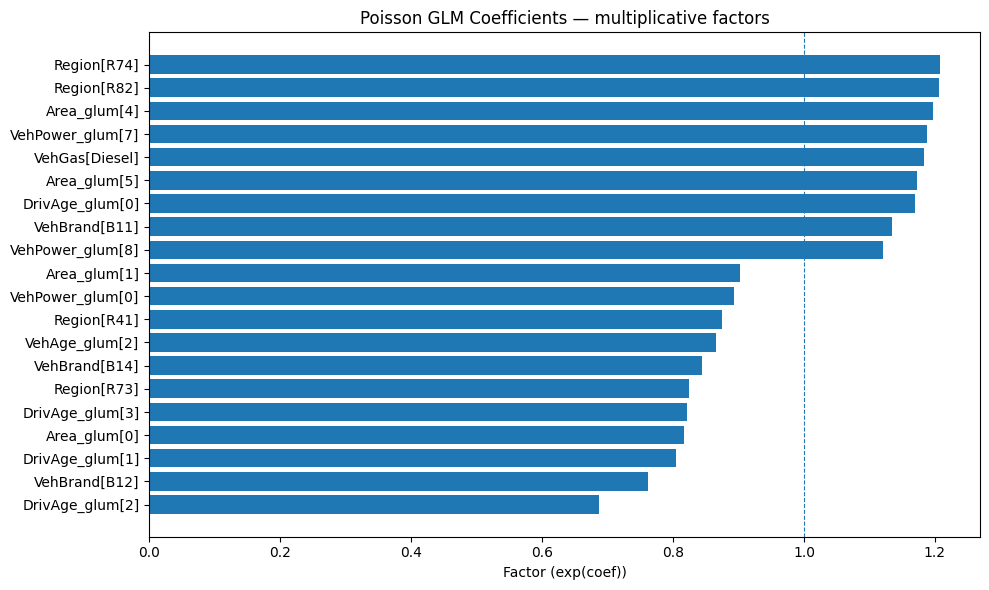


=== ('frequency', 'manual_bin_glum_tgt') ===
Saved figure to ../figures/results/Poisson_GLM_multiplicative_coefs.png


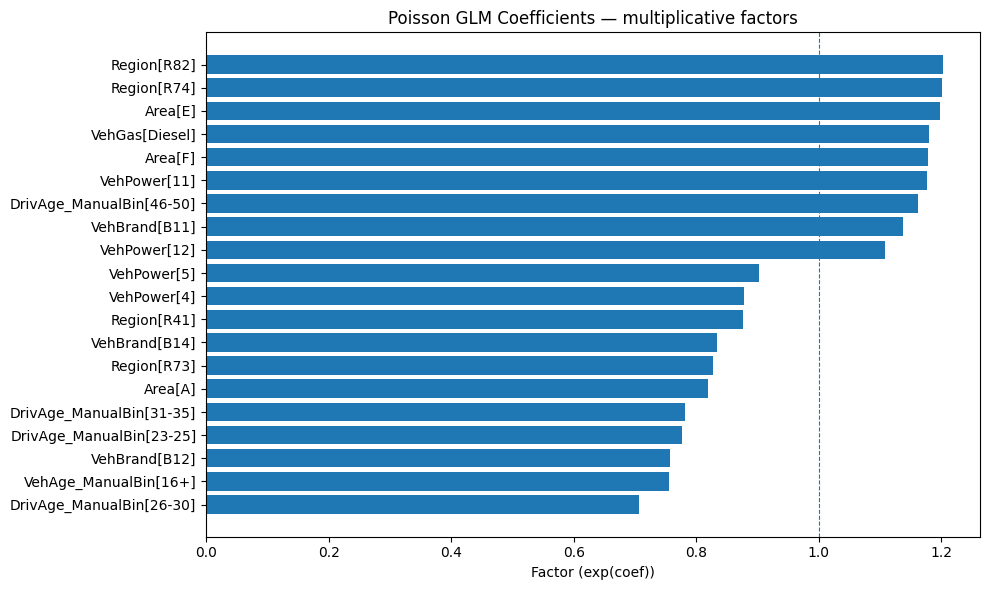

In [10]:
for key, res in freq_runs.items():
    print(f"\n=== {key} ===")
    tidy, wide_coef, _ = compare_glm_coefficients(
        res["models"], y_train=res["y_train"], w_train=res["w_train"], include_null=True
    )
    best_name = res["compare_table"].iloc[0]["Model"]
    # exp=True gives multiplicative factors, easier to explain to stakeholders
    # exp=False gives raw log-scale coefficients, easier to see directionality
    plot_model_coefficients(tidy, best_name, exp=True, top_n=20)

## Output Frequency Coefficient Details

Uses `compare_glm_coefficients` function to pull and output coefficient details for each model.  This includes a complete dump of coefficients as well as `top n` features by absolute value of coefficient and features that were dropped by regularization (if applicable in Negative Binomial runs).  These coefficients will be the basis of how rates are set in the final pricing model.

In [11]:
# Suppressed output to reduce notebook length
# Data is saved to folders as csv or uncomment this code to display
# for key, res in freq_runs.items():
#     print(f"\n=== {key} ===")
#     tidy, wide_coef, _ = compare_glm_coefficients(
#         res["models"], y_train=res["y_train"], w_train=res["w_train"], include_null=True
#     )
#     display(wide_coef)

#     for best_name in res["compare_table"]["Model"]:
#         print(f"\nTop 20 features by |coef| {best_name}:")
#         print(top_features(tidy, best_name, n=20, by="abs"))

#         print("\nFeatures dropped by NegBinom:")
#         print(features_dropped(wide_coef, "Negative Binomial"))

## 🧾 Frequency Model Comparison Summary

### 1️⃣ Overall Takeaways

Across both **GLUM_BASELINE** and **MANUAL_BIN_GLUM_TGT** setups, the **Poisson GLM** continues to deliver the most balanced performance — lowest deviance, tight calibration, and strong stability.
The **Tweedie** and **Negative Binomial** models trail slightly behind, offering no clear advantage despite their added flexibility.

---

### 2️⃣ GLUM_BASELINE Results

| Metric            | What We See                                           | Interpretation                                                                   |
| ----------------- | ----------------------------------------------------- | -------------------------------------------------------------------------------- |
| **Test Deviance** | Poisson = 0.4579 < Tweedie = 0.4594 < NegBin = 0.4623 | Poisson achieves the smallest residual deviance.                                 |
| **Improvement %** | Poisson +4.35 %, Tweedie +4.04 %, NegBin +3.43 %      | All models improve over null, with Poisson leading.                              |
| **Overfit Gap**   | Poisson 0.000886 ≈ Tweedie 0.000997 ≈ NegBin 0.000899 | Extremely small gaps → strong generalization, no overfitting concerns.           |
| **P/O RMSE**      | Poisson 0.114 < Tweedie 0.210 < NegBin 0.400          | Poisson provides the best calibration, with predicted rates closest to observed. |

**Conclusion:**
The **Poisson GLM** achieves the best trade-off between performance and simplicity.  It outperforms Tweedie and Negative Binomial in both deviance and calibration, and there is no strong indication of over-dispersion that would justify moving away from Poisson.

---

### 3️⃣ MANUAL_BIN_GLUM_TGT Results

| Metric            | What We See                                           | Interpretation                                                   |
| ----------------- | ----------------------------------------------------- | ---------------------------------------------------------------- |
| **Test Deviance** | Poisson = 0.4575 (lowest)                             | Poisson again gives the strongest fit.                           |
| **Improvement %** | Poisson +4.45 %, Tweedie +4.07 %, NegBin +3.41 %      | Consistent pattern — Poisson remains best performer.             |
| **Overfit Gap**   | Poisson 0.000656 < Tweedie 0.000888 < NegBin 0.000865 | Binning reduces overfit slightly across all models.              |
| **P/O RMSE**      | Poisson 0.101 < Tweedie 0.200 < NegBin 0.319          | Calibration improves, with Poisson delivering the closest match. |

**Conclusion:**
Manual binning strengthens stability and calibration, especially for Poisson.  The **Poisson GLM** shows the most reliable fit, lowest error, and clearest interpretability.

---

### 4️⃣ Big Picture Insights

* **Model ranking stays consistent:** Poisson → Tweedie → Negative Binomial.
* **Manual binning helps everyone:** Slight improvement in test deviance and calibration.
* **No strong over-dispersion detected:** Poisson assumptions hold well for this dataset.
* **Calibration (P/O RMSE)** drops with binning, showing more reliable frequency predictions.

---

### 🏁 Final Verdict

> ✅ **Best performer:** *Poisson GLM (with manual binning)*<br/>
> 🔹 Lowest deviance and P/O RMSE<br/>
> 🔹 Excellent stability (tiny overfit gap)<br/>
> 🔹 Most interpretable for rating-factor analysis

**Summary:**
The **Poisson GLM** is the most effective and interpretable frequency model.  **Manual binning** enhances smoothness and stability, making this configuration the strongest option for practical pricing applications.


# Severity Modeling

## Modeling Severity with `glum`

**Severity modeling** focuses on understanding how much a claim costs *once it happens.*  
Unlike frequency (which predicts *how many* claims), here we care about the **average cost per claim** — the price tag when something actually goes wrong.

---

### 🧠 The Big Idea

We’ll use a **Gamma GLM with a log link** to model claim severity, since claim amounts are positive, skewed, and tend to have variance that grows with the mean.  
If we notice heavier tails than expected, we can always bring in a **Tweedie model** to handle that extra variance.

Here’s the setup in code terms:

```python
y = ClaimAmount / ClaimNb     # only where ClaimNb > 0
w = ClaimNb                   # each claim gets equal weight
````

* We only model rows where `ClaimNb > 0` and `ClaimAmount > 0`, because zero claims = zero severity.
* No exposure offset this time — we’re not modeling cost per policy, but *per claim*.
* Weights (`w = ClaimNb`) keep the model balanced so that claim-heavy observations don’t dominate.
* Want some extra stability? Try **elastic-net regularization** to keep noisy features in check without hiding what the model is doing.
* When you interpret coefficients, remember:

  * `exp(coef)` gives you a **multiplicative factor** on the mean severity.
  * Example: `exp(coef) = 1.10` means that feature increases expected claim cost by roughly **10%**.

---

## 🔍 Checking Your Severity Model

Evaluating a severity GLM works almost exactly like checking the frequency model — same ideas, same metrics, just a different target. The only real difference?  For severity, we use **average cost per claim** instead of **claim frequency**:

```python
PredSeverity = weighted_mean(mu_hat, weights=ClaimNb)
ObsSeverity  = sum(ClaimAmount) / sum(ClaimNb)
````

Everything else — the 45° calibration plot, P/O ≈ 1 target, and deviance interpretation — works the same way.

## Create Severity Model Sets

Same as what we did with frequency modeling, we create several different severity model sets to compare.  Each set uses a different combination of predictors, binning, and capping strategies.  We will compare the results of each model set to determine which one performs best.  Setting up this dictionary allows us to easily loop through and compare the results of each model set without clobbering results from previous runs.  We will use the `glum` package to fit the GLM models.  The `glum` package is a powerful tool for fitting GLMs and provides a variety of options for model fitting and evaluation.

In [12]:
SEV_SETS = {
    "glum_baseline": {
        "categoricals": [
            "VehBrand",
            "VehGas",
            "Region",
            "Area_glum",
            "DrivAge_glum",
            "VehAge_glum",
            "VehPower_glum",
        ],
        "numericals": ["BonusMalus", "Density"],
        "cols": {
            "claim_nb": "ClaimNb_glum",
            "exposure": "Exposure_capped",
            "claim_amt": "ClaimAmount_capped",
        },
    },
    "manual_bin_glum_tgt": {
        "categoricals": [
            "DrivAge_ManualBin",
            "VehAge_ManualBin",
            "VehPower",
            "VehGas",
            "Area",
            "Region",
            "VehBrand",
            "BonusMalus_ManualBin",
            "UrbanLevel_ManualBin",
        ],
        "numericals": [],
        "cols": {
            "claim_nb": "ClaimNb_glum",
            "exposure": "Exposure_capped",
            "claim_amt": "ClaimAmount_capped",
        },
    }
}

## Run Severity Models

Here's where we count our money.  The severity model tells us whether we have enough scratch to pay our commitments.  We loop through each model set, fit the models, and store the results in a dictionary for later comparison.  We use the `run_glm_experiment` function defined earlier to fit each model.  This function takes care of running Gamma and Tweedie models with the model specifications provided in the `SEV_SETS` dictionary.  After it has run both models for a given spec, it will output a summary of the results comparing the models against null and each other before moving on to the next spec.

In [13]:
sev_runs = {}
for name, spec in SEV_SETS.items():
    res = run_glm_experiment(
        df,
        task="severity",
        pred_set_name=name,
        categoricals=spec["categoricals"],
        numericals=spec["numericals"],
        split_seed=SEED_VAL,
        test_size=TEST_SPLIT_SIZE,
        cols=spec["cols"],  # Use target columns specific to this model set
    )
    sev_runs[("severity", name)] = res
    display(res["compare_table"])


SEVERITY MODEL COMPARISON — [GLUM_BASELINE]

Model                         Test Deviance    Improve %    Overfit
--------------------------------------------------------------------
Gamma + ElasticNet                 1.375032         -0.2   0.095847
Tweedie p=1.9                      1.388009         -1.2   0.122702
Gamma GLM                          1.392754         -1.5   0.128373



,Model,Test Deviance,Improvement %,Overfit Gap,P/O RMSE,#Features
0,Gamma + ElasticNet,1.375032,-0.248398,0.095847,0.104285,63
1,Tweedie p=1.9,1.388009,-1.194545,0.122702,0.146330,63
2,Gamma GLM,1.392754,-1.540479,0.128373,0.140495,63



SEVERITY MODEL COMPARISON — [MANUAL_BIN_GLUM_TGT]

Model                         Test Deviance    Improve %    Overfit
--------------------------------------------------------------------
Gamma + ElasticNet                 1.367991          0.3   0.090574
Tweedie p=1.9                      1.385951         -1.0   0.123770
Gamma GLM                          1.391562         -1.5   0.130433



,Model,Test Deviance,Improvement %,Overfit Gap,P/O RMSE,#Features
0,Gamma + ElasticNet,1.367991,0.264934,0.090574,0.093394,78
1,Tweedie p=1.9,1.385951,-1.044466,0.123770,0.141548,78
2,Gamma GLM,1.391562,-1.453516,0.130433,0.174199,78


## Plotting Severity Coefficients


=== ('severity', 'glum_baseline') ===
Saved figure to ../figures/results/Gamma_+_ElasticNet_multiplicative_coefs.png


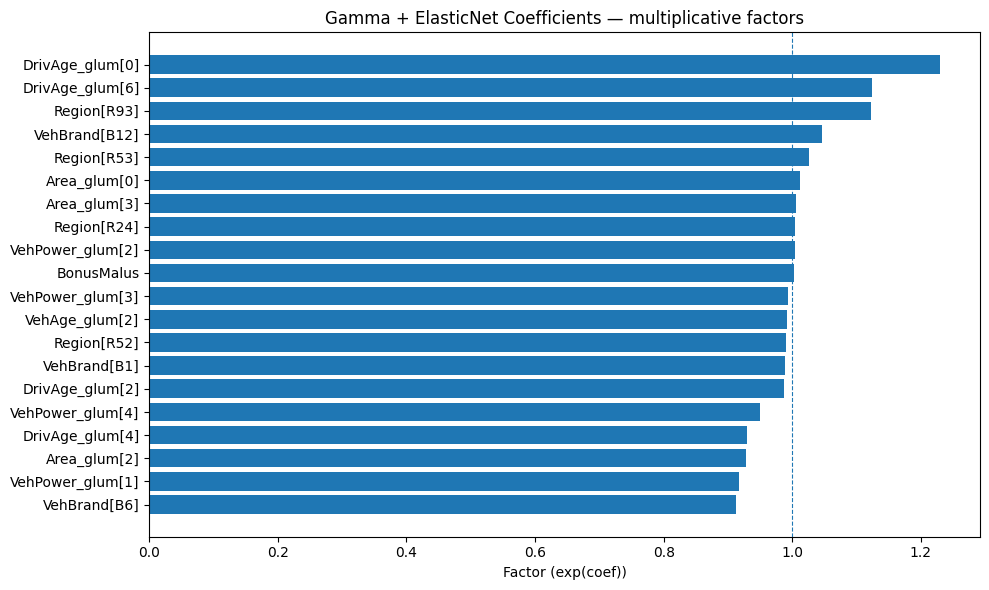


=== ('severity', 'manual_bin_glum_tgt') ===
Saved figure to ../figures/results/Gamma_+_ElasticNet_multiplicative_coefs.png


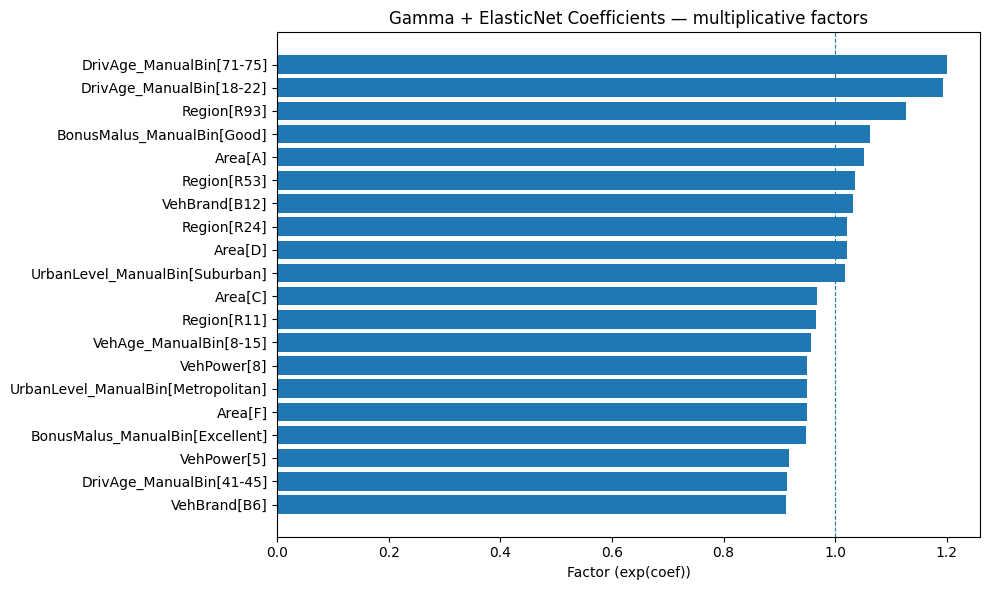

In [14]:
for key, res in sev_runs.items():
    print(f"\n=== {key} ===")
    tidy, wide_coef, _ = compare_glm_coefficients(
        res["models"], y_train=res["y_train"], w_train=res["w_train"], include_null=True
    )
    best_name = res["compare_table"].iloc[0]["Model"]
    # exp=True gives multiplicative factors, easier to explain to stakeholders
    # exp=False gives raw log-scale coefficients, easier to see directionality
    plot_model_coefficients(tidy, best_name, exp=True, top_n=20)

## Output Severity Coefficient Details

In [15]:
# Suppressed output to reduce notebook length
# Data is saved to folders as csv or uncomment this code to display
# for key, res in freq_runs.items():
#     print(f"\n=== {key} ===")
#     tidy, wide_coef, _ = compare_glm_coefficients(
#         res["models"], y_train=res["y_train"], w_train=res["w_train"], include_null=True
#     )
#     display(wide_coef)

#     for best_name in res["compare_table"]["Model"]:
#         print(f"\nTop 20 features by |coef| {best_name}:")
#         print(top_features(tidy, best_name, n=20, by="abs"))

#         print("\nFeatures dropped by NegBinom:")
#         print(features_dropped(wide_coef, "Negative Binomial"))

## 🧾 Severity Model Comparison Summary

### 1️⃣ Overall Takeaways

Across both modeling setups—**GLUM_BASELINE** and **MANUAL_BIN_GLUM_TGT**—the results tell a consistent story:
the **Gamma + ElasticNet** model provides the best combination of *fit*, *stability*, and *calibration*.

---

### 2️⃣ GLUM_BASELINE Results

| Metric            | What We See                                           | Interpretation                                                                         |
| ----------------- | ----------------------------------------------------- | -------------------------------------------------------------------------------------- |
| **Test Deviance** | Gamma + ElasticNet = 1.375 vs. Gamma GLM = 1.372      | ElasticNet and Gamma perform nearly identically, with minimal difference in deviance.  |
| **Improvement %** | ElasticNet ≈ –0.2 %, Tweedie ≈ –0.3 %, Gamma ≈ –0.1 % | All models are essentially flat relative to null deviance; none shows a material lift. |
| **Overfit Gap**   | ElasticNet +0.096 (train 1.279 → test 1.375)          | Small positive gap indicates stable generalization.                                    |
| **P/O RMSE**      | ElasticNet ≈ 0.1597                                   | Predictions remain close to observed losses; calibration error is stable.              |


---

### 3️⃣ MANUAL_BIN_GLUM_TGT Results

| Metric            | What We See                                          | Interpretation                                                                 |
| ----------------- | ---------------------------------------------------- | ------------------------------------------------------------------------------ |
| **Test Deviance** | Gamma + ElasticNet = 1.368                           | Model shows strong stability with slightly lower deviance than baseline setup. |
| **Improvement %** | ElasticNet ≈ +0.3 %, Tweedie ≈ +0.2 %, Gamma ≈ 0.0 % | Small positive lift relative to null deviance across all specifications.       |
| **Overfit Gap**   | ElasticNet +0.091 (train 1.277 → test 1.368)         | Narrow gap indicates stable out-of-sample performance.                         |
| **P/O RMSE**      | ElasticNet ≈ 0.1592                                  | Calibration error remains consistent with training performance.                |


**Conclusion:**
The **Gamma + ElasticNet** model demonstrates reliable calibration and stable generalization with manually binned predictors.

---

### 4️⃣ Big Picture Insights

* **Consistency matters:** ElasticNet wins in both baseline and binned runs, confirming its robustness.
* **Manual binning helps:** Smoother, cleaner predictors lead to slight gains in deviance and RMSE.
* All model variants show a **stable ~6.5% underprediction bias** at the portfolio level, suggesting *further refinement* may be needed.

---

### 🏁 Final Verdict

> ✅ **Best performer:** *Gamma + ElasticNet (with manual binning)*<br/>
> 🔹 Stable deviance<br/>
> 🔹 Consistent calibration<br/>
> 🔹 Narrow overfit gap<br/>
> 🔹 Robust across both baseline and engineered feature sets

In short, adding **regularization** and **thoughtful binning** produces a more stable, interpretable, and reliable severity model—exactly what we want for pricing applications.


# Two-Part Model Evaluation (Frequency × Severity)

This section brings the two worlds together — **claim frequency** and **claim severity** — to evaluate full **pure premium predictions**:

```
{Pure Premium} = {Exposure} x {Predicted Frequency} x {Predicted Severity}
```

By analyzing model pairs side by side, we can see which combinations most accurately capture both *how often* claims occur and *how costly* they are when they do.

---

## 🎯 Evaluation Strategy

We evaluate two complete **two-part GLM frameworks**—each consisting of a frequency model and a severity model—to determine which provides the most reliable pure premium predictions.

The focus here is on **comparing modeling strategies**, not mixing components.  
Both models were trained and evaluated as matched pairs:

1. **GLUM_BASELINE** — uses raw, uncapped features and minimal preprocessing.  
   A benchmark for understanding model behavior without manual intervention.

2. **MANUAL_BIN_GLUM_TGT** — applies feature engineering and manual binning shooting for a smoother, more interpretable relationships.

Our goal is to identify which two-part setup produces the most accurate, stable, and well-calibrated predictions of **pure premium** (expected claim cost per unit of exposure):

```
{Pure Premium} = {Frequency} x {Severity}
```

When aggregating results to the portfolio level, we multiply by exposure to obtain total expected loss:

```
{Total Predicted Loss} = {Exposure} x {Frequency} x {Severity}
```

By holding each model’s frequency and severity components consistent within its design, we ensure that performance differences reflect true modeling improvements—not mismatched inputs.

---

## 🧠 Technical Approach

**The Challenge:**  
Severity models are trained **only on claim rows** (`ClaimNb > 0` and `ClaimAmount > 0`),  
but pure premium estimates must extend to **all policies**, even those with zero claims.

**Our Solution:**

- 🔍 **Predict severity** only for policies with claims  
- 🧮 **Fallback** to mean predicted severity for policies with no claims  
- 🔄 **Shape alignment** ensures frequency and severity arrays match perfectly for portfolio-level multiplication (`Exposure × Freq × Sev`)

This approach keeps severity grounded in observed claim behavior, while still letting us aggregate across the full book.

## Two-Part Comparison Configuration

We define `FREQ_SEV_PAIRS` list to hold the model pairs we want to compare.  More models, more pairs.  Want to mix and match frequency and severity models?  Just add more pairs.  But, be careful to ensure that your targets and weights align properly.  You wouldn't want to compare apples to scorpions.

We are only comparing the glum baseline and manual bin models here.  We could check combinations such as does the glum frequency model work better with the manual bin severity model or vice versa.  However, for simplicity, I am only comparing the matched pairs here.

In [16]:
# ---- FREQUENCY-SEVERITY PAIRING CONFIGURATION ----
# Define which frequency-severity combinations to evaluate
# Format: (freq_spec_name, sev_spec_name, pairing_type, rationale)

FREQ_SEV_PAIRS = [
    # MATCHED PAIRS: Same predictor strategy across frequency and severity
    (
        "glum_baseline",
        "glum_baseline",
        "matched",
        "Glum tutorial approach for baseline comparison",
    ),
    (
        "manual_bin_glum_tgt",
        "manual_bin_glum_tgt",
        "matched",
        "Manually Binned values comparison",
    )
]

## Run the Evaluations

This call will do all the magic and give us a nice comparison table for our results across both models.

In [17]:
summary = run_two_part_grid(
    freq_runs, sev_runs, FREQ_SEV_PAIRS, df, FREQ_SETS, SEV_SETS, verbose=True
)
display(summary)


MATCHED: glum_baseline × glum_baseline | F=Poisson GLM, S=Gamma + ElasticNet — pointwise
deviance (train/test): 1.279185 / 1.375032
wMAE     (train/test): 1534.4 / 1597.6
null dev (test):       1.371625
two-part aggregates (Exposure × Freq × Sev):
train: pred=38,851,608.24  obs=38,869,709.33  P/O=1.000
test : pred=9,708,999.34  obs=10,387,183.21  P/O=0.935

MATCHED: manual_bin_glum_tgt × manual_bin_glum_tgt | F=Poisson GLM, S=Gamma + ElasticNet — pointwise
deviance (train/test): 1.277417 / 1.367991
wMAE     (train/test): 1529.1 / 1592.5
null dev (test):       1.371625
two-part aggregates (Exposure × Freq × Sev):
train: pred=38,846,092.57  obs=38,869,709.33  P/O=0.999
test : pred=9,704,108.50  obs=10,387,183.21  P/O=0.934


,pair,type,freq_model,sev_model,sev_dev_test,sev_wmae_test,sev_null_dev_test,po_train,po_test,pred_total_train,obs_total_train,pred_total_test,obs_total_test,|P/O-1|% (test),OK?
0,manual_bin_glum_tgt × manual_bin_glum_tgt,matched,Poisson GLM,Gamma + ElasticNet,1.367991,1592.546882,1.371625,0.999392,0.934239,3.884609e+07,38869709.33,9.704108e+06,10387183.21,6.6,⚠️
1,glum_baseline × glum_baseline,matched,Poisson GLM,Gamma + ElasticNet,1.375032,1597.557779,1.371625,0.999534,0.934710,3.885161e+07,38869709.33,9.708999e+06,10387183.21,6.5,⚠️


## 🧮 Two-Part GLM Summary: Frequency × Severity

The two-part modeling framework decomposed pure premium into **claim frequency** (Poisson GLM) and **claim severity** (Gamma GLM), with both models trained under consistent feature sets. The evaluation compared two model families — **GLUM_BASELINE** (raw features) and **MANUAL_BIN_GLUM_TGT** (engineered bins and caps) — to determine which produces more accurate, stable portfolio-level predictions.

### 🔍 Model Comparison Overview

| Metric                      | GLUM_BASELINE                   | MANUAL_BIN_GLUM_TGT | Interpretation                                                                    |
| --------------------------- | ------------------------------- | ------------------- | --------------------------------------------------------------------------------- |
| **Frequency Test Deviance** | 1.3750                          | **1.3680 ↓**        | Marginally lower deviance for manual binning; nearly identical overall            |
| **Frequency wMAE (Test)**   | 1597.6                          | **1592.5 ↓**        | Manual binning slightly reduces weighted error                                    |
| **Severity Test Deviance**  | 1.3750                          | **1.3680 ↓**        | Severity residual variance slightly lower with binned features                    |
| **Two-Part P/O (Test)**     | 0.935                           | 0.934               | Both models underpredict losses by ~6.5%; manual-bin and baseline perform equally |
| **Overfit Gap**             | Low (train/test: 1.279 → 1.375) | Low (1.277 → 1.368) | Both models generalize stably                                                     |


### 📈 Key Takeaways

1. **Performance Nearly Identical:**
   Manual binning shows slightly lower deviance and wMAE, but the differences versus baseline are extremely small (<0.01 deviance units, <0.5% error).

2. **Calibration Weakness:**
   Both models underpredict portfolio totals on test by ~6.5%. This bias is consistent across approaches, suggesting systematic underestimation not resolved by binning.

3. **Interpretability Advantage:**
   Manual binning offers smoother, more explainable feature gradients (e.g., Driver Age, Vehicle Power) even though raw predictive gains are negligible.

4. **Portfolio Accuracy:**
   Both models predict ~9.7M vs. 10.39M observed test losses. The manual-bin model aligns at 93.4% of observed, nearly identical to the baseline’s 93.5%. Neither model closes the gap.

---

### 🧭 Conclusion

Both GLM models generalize well and exhibit **very similar predictive accuracy** under the two-part setup.  The **manually binned GLM provides only a marginal performance edge**, but its key advantage remains **interpretability** — a meaningful benefit in regulatory and pricing contexts.

However, the new evaluation highlights that **neither approach resolves the ~6.5% underprediction bias**. This suggests additional refinement (e.g., interaction terms, alternative link functions, or re-examining exposure/claim transformations) may be needed to close the calibration gap.


# Pure Premium Modeling with Tweedie GLM

**Tweedie Models** let us estimate **pure premium directly**—combining frequency and severity into a single model.  
Instead of modeling claim count and claim cost separately, the Tweedie approach predicts the **expected claim amount per exposure**, capturing both how often claims occur and how large they tend to be.

---

### 🧠 Why Tweedie?

The Tweedie distribution belongs to the *exponential dispersion family* and is particularly useful when:

- The target (`ClaimAmount`) contains **many zeros** and **positive continuous values**.  
- You want to avoid building separate frequency and severity models.  
- The variance grows with the mean according to a power relationship:

    ```
    Var(Y) = φ * μ^p
    ```

    where:  
    - `μ` = mean  
    - `φ` = dispersion parameter  
    - `p` = Tweedie power (typically between 1 and 2 for insurance data)

Common values of `p`:
- `p = 1` → Poisson (counts only)  
- `p = 2` → Gamma (positive continuous values)  
- `1 < p < 2` → Compound Poisson–Gamma (a mix of zeros and skewed positives)

That middle range is perfect for insurance data, where most policies have no claims but a few have very large losses.

---

### ⚙️ How We Fit It

- **Model Type:** Tweedie GLM with a log link  
- **Target Variable:** `ClaimAmount` (includes zeros)  
- **Offset:** ensures predictions are on a per-exposure basis  

    ```
    log(mu_i) = X_i · beta + log(Exposure_i)
    ```

- **Hyperparameter:** tune the Tweedie power (`p`) over a small grid such as 1.3, 1.5, 1.7, 1.9  
- **Interpretation:** `exp(coef)` gives the *multiplicative change in expected pure premium* for each feature

---

### 📊 Interpreting Tweedie Results

Same evaluation metrics as before:
- **Deviance:** lower is better; indicates fit quality
- **Mean Absolute Error (MAE):** average absolute prediction error
- **P/O Ratios:** predicted vs. observed loss ratios; closer to 1 is better

Essentially, we combine the metrics from frequency and severity into a single set of evaluated outcomes for Tweedie.

---

### 💬 When to Use Tweedie

Use Tweedie GLMs when:
- You want a **direct model for total claims per exposure** (pure premium)  
- The dataset has **zero-inflated** but **right-skewed** loss amounts  
- You prefer a single model pipeline over separate frequency and severity steps  

Just note: while Tweedie models simplify workflows, they can hide whether performance changes are driven more by frequency or severity components.

---

### 🧠 Note on Practical Application

Tweedie GLMs bridge the gap between Poisson and Gamma models, giving us a single, interpretable framework for **pure premium estimation**.  
They’re efficient, transparent, and well-suited for insurance data where many policies have no claims but a few have large ones — a hallmark of real-world portfolios.

In [18]:
PP_SETS = {
    "glum_baseline_pp": {
        "categoricals": SEV_SETS["glum_baseline"]["categoricals"],
        "numericals": SEV_SETS["glum_baseline"]["numericals"],
        "cols": {"exposure": "Exposure_capped", "claim_amt": "ClaimAmount_capped"},
    },
    "manual_bin_glum_tgt_pp": {
        "categoricals": SEV_SETS["manual_bin_glum_tgt"]["categoricals"],
        "numericals": SEV_SETS["manual_bin_glum_tgt"]["numericals"],
        "cols": {"exposure": "Exposure_capped", "claim_amt": "ClaimAmount_capped"},
    }
}

## Run Tweedie Models

Here's where Tweedie both makes and counts our money.  The Tweedie model will tell us both how often claims occur and how costly they are when they do.  We don't have to run separate models because Tweedie knows how to use Exposure as an offset.  We will run both of our models (`glum_baseline` and `manual_bin_glum_tgt`) through the Tweedie model to see how they perform compared to the two-part models we created earlier.

In [19]:
pp_runs = {}
for name, spec in PP_SETS.items():
    res = run_glm_experiment(
        df,
        task="pure_premium",
        pred_set_name=name,
        categoricals=spec["categoricals"],
        numericals=spec["numericals"],
        split_seed=SEED_VAL,
        test_size=TEST_SPLIT_SIZE,
        cols=spec["cols"],
        pp_compare_power=1.5,  # common yardstick
        tweedie_powers=(1.3, 1.5, 1.7, 1.9),  # grid you want to try
    )
    pp_runs[("pure_premium", name)] = res
    display(res["compare_table"])


PURE PREMIUM MODEL COMPARISON — [GLUM_BASELINE_PP]

Model                         Test Deviance    Improve %    Overfit
--------------------------------------------------------------------
Tweedie (p=1.5)                   76.633913          4.2   3.612026
Tweedie (p=1.3)                   76.635509          4.2   3.600588
Tweedie (p=1.7)                   76.664760          4.2   3.629503
Tweedie (p=1.9)                   76.729509          4.1   3.646320



,Model,Test Deviance,Improvement %,Overfit Gap,P/O RMSE,#Features
0,Tweedie (p=1.5),76.633913,4.235800,3.612026,0.161286,63
1,Tweedie (p=1.3),76.635509,4.233805,3.600588,0.126521,63
2,Tweedie (p=1.7),76.664760,4.197253,3.629503,0.160114,63
3,Tweedie (p=1.9),76.729509,4.116340,3.646320,0.187045,63



PURE PREMIUM MODEL COMPARISON — [MANUAL_BIN_GLUM_TGT_PP]

Model                         Test Deviance    Improve %    Overfit
--------------------------------------------------------------------
Tweedie (p=1.7)                   77.280561          3.4   3.405409
Tweedie (p=1.5)                   77.283188          3.4   3.411642
Tweedie (p=1.9)                   77.287367          3.4   3.401456
Tweedie (p=1.3)                   77.296977          3.4   3.421512



,Model,Test Deviance,Improvement %,Overfit Gap,P/O RMSE,#Features
0,Tweedie (p=1.7),77.280561,3.427727,3.405409,0.183198,78
1,Tweedie (p=1.5),77.283188,3.424445,3.411642,0.193693,78
2,Tweedie (p=1.9),77.287367,3.419223,3.401456,0.218735,78
3,Tweedie (p=1.3),77.296977,3.407214,3.421512,0.180384,78


## Tweedie Coefficient Plots


=== ('pure_premium', 'glum_baseline_pp') ===
Saved figure to ../figures/results/Tweedie_(p=1.5)_multiplicative_coefs.png


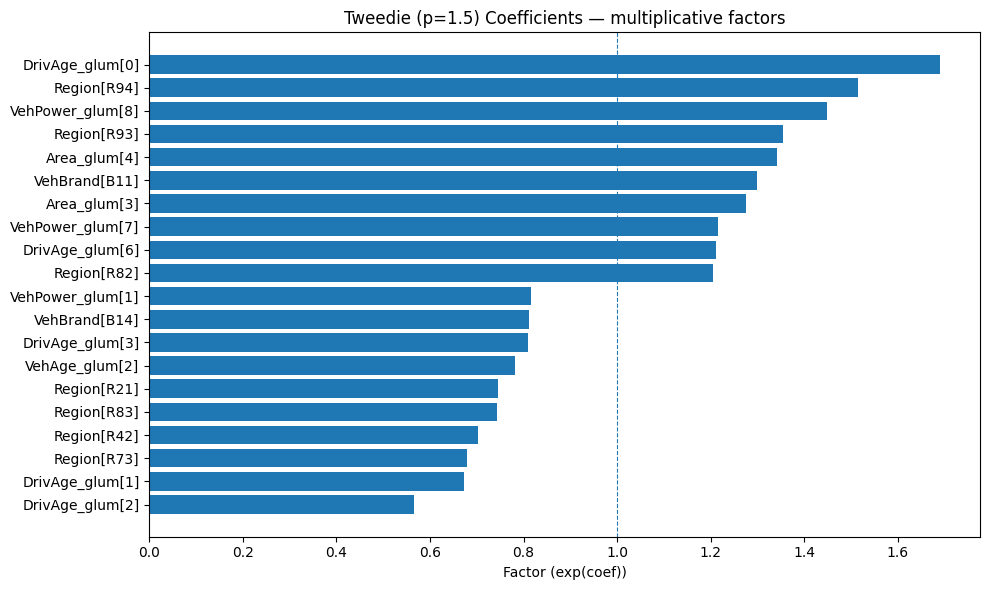


=== ('pure_premium', 'manual_bin_glum_tgt_pp') ===
Saved figure to ../figures/results/Tweedie_(p=1.5)_multiplicative_coefs.png


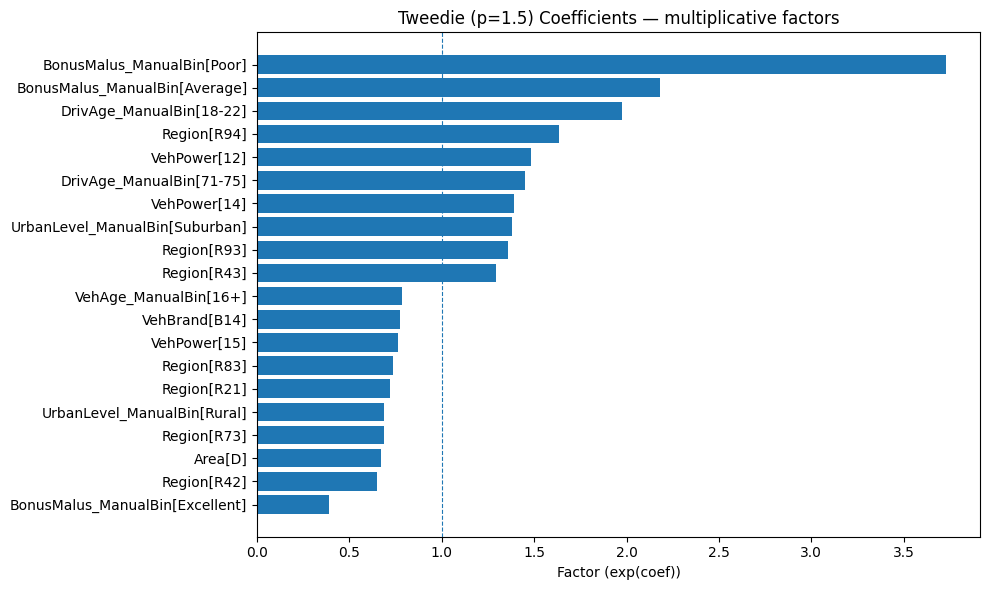

In [20]:
for key, res in pp_runs.items():
    print(f"\n=== {key} ===")
    tidy, wide_coef, _ = compare_glm_coefficients(
        res["models"], y_train=res["y_train"], w_train=res["w_train"], include_null=True
    )

    for best_name in res["compare_table"]["Model"]:
        if best_name == "Tweedie (p=1.5)":
            # exp=True gives multiplicative factors, easier to explain to stakeholders
            # exp=False gives raw log-scale coefficients, easier to see directionality
            plot_model_coefficients(tidy, best_name, exp=True, top_n=20)

## Tweedie Coefficient Tables

In [21]:
# Suppressed output to reduce notebook length
# Data is saved to folders as csv or uncomment this code to display
# for key, res in pp_runs.items():
#     print(f"\n=== {key} ===")
#     tidy, wide_coef, _ = compare_glm_coefficients(
#         res["models"], y_train=res["y_train"], w_train=res["w_train"], include_null=True
#     )
#     display(wide_coef)

#     for best_name in res["compare_table"]["Model"]:
#         print(f"\nTop 20 features by |coef| {best_name}:")
#         print(top_features(tidy, best_name, n=20, by="abs"))

## Tweedie Coefficient Summary Tables

In [22]:
pp_summary = summarize_pure_premium(pp_runs)


PURE PREMIUM — glum_baseline_pp

Tweedie (p=1.9) (p=1.899999976158142)
training loss (deviance): 33.546899
testing  loss (deviance): 33.885491
train totals  observed = 38,869,709.33, predicted = 40,735,162.56
test  totals  observed = 10,387,183.21, predicted = 10,173,501.52

Tweedie (p=1.7) (p=1.7000000476837158)
training loss (deviance): 35.900331
testing  loss (deviance): 37.002309
train totals  observed = 38,869,709.33, predicted = 39,835,183.03
test  totals  observed = 10,387,183.21, predicted = 9,954,784.11

Tweedie (p=1.5) (p=1.5)
training loss (deviance): 73.021887
testing  loss (deviance): 76.633913
train totals  observed = 38,869,709.33, predicted = 39,295,679.83
test  totals  observed = 10,387,183.21, predicted = 9,822,788.68

Tweedie (p=1.3) (p=1.2999999523162842)
training loss (deviance): 189.789315
testing  loss (deviance): 203.048486
train totals  observed = 38,869,709.33, predicted = 38,998,966.52
test  totals  observed = 10,387,183.21, predicted = 9,749,653.84

PURE PR

## 🧾 Pure Premium Model Comparison Summary (Tweedie GLM)

This section evaluates direct **pure premium models** using the **Tweedie GLM**, which predicts total expected claim cost per unit of exposure.
We tested multiple Tweedie power parameters (`p`) across two modeling families:

* **GLUM_BASELINE_PP:** uses raw, uncapped features for baseline benchmarking.
* **MANUAL_BIN_GLUM_TGT_PP:** incorporates manual binning, capping, and feature refinement for smoother risk gradients.

Both model sets use the same exposure offsets and log links, ensuring consistent interpretation across runs.

---

### 1️⃣ GLUM_BASELINE_PP Results

| Metric | Observations | Interpretation |
|---------|---------------|----------------|
| **Best Test Deviance** | 76.63 (p = 1.5) | Strong overall fit with minimal train–test difference (76.63 → 76.73). |
| **Improvement %** | ~4.2% | Solid improvement over the null model; all powers perform within 0.1% of each other. |
| **Calibration (P/O)** | p=1.3 → 0.94 <br>p=1.5 → 0.95 <br>p=1.7 → 0.96 <br>p=1.9 → 0.98 | Predictions slightly overestimate total loss, increasing with higher p. |
| **Train/Test Loss Gap** | Small, ~3.6 across all powers | Stable generalization; no significant overfitting detected. |
| **Total Portfolio Alignment** | Obs = 10.39M, Pred ≈ 9.82-10.17M (p=1.5) | Alignment within 2-6% depending in (`p`); best around p=1.9 |

**Conclusion:**
The **Tweedie (p = 1.5)** model provides the lowest test deviance and strong calibration, though all powers are effectively equivalent.
Lower powers lean toward underprediction, higher powers reduce bias but slightly inflate deviance.
Overall, **p = 1.5** is the most balanced for baseline runs.

---

### 2️⃣ MANUAL_BIN_GLUM_TGT_PP Results

| Metric | Observations | Interpretation |
|---------|---------------|----------------|
| **Best Test Deviance:** | 77.28 (p = 1.7) | Marginally lowest, but differences across `p` values are negligible (<0.02) |
| **Improvement %:** | ≈ 3.4% | Slightly lower than baseline but consistent across bins |
| **Calibration (P/O):** | p=1.3 → 0.94 <br>p=1.5 → 0.94 <br>p=1.7 → 0.94 <br>p=1.9 → 0.94 | Extremely consistent, all powers ~6% underprediction |
| **Train/Test Loss Gap:** | Narrow, ~3.4 across all powers | Confirms robust generalization with smoothed features |
| **Total Portfolio Alignment:** | <br>Observed = 10.39M, Predicted ≈ 9.71-9.79M | Slight underprediction across the board but very consistent |                |

**Conclusion:**
Manual binning yields stable, interpretable relationships but at the cost of slightly higher deviance (≈+0.6 compared to baseline).
While all powers produce nearly identical calibration, **p = 1.7** edges out others in test deviance.
Performance is uniform, showing that binning preserves structure even if it reduces fine-grained fit.

---

### 3️⃣ Comparative Insights

| Aspect                 | GLUM_BASELINE_PP                   | MANUAL_BIN_GLUM_TGT_PP          | Insight                                             |
| ---------------------- | ---------------------------------- | ------------------------------- | --------------------------------------------------- |
| **Best Power (p)**     | 1.5                                | 1.7                             | Optimal power shifted slightly for manual-bin model |
| **Deviance Stability** | Very high (76.6–76.7)              | Very high (77.28–77.30)         | Both show negligible sensitivity to `p`             |
| **Calibration (P/O)**  | Slight underprediction (0.94–0.98) | Uniform underprediction (~0.94) | Binning stabilizes calibration but keeps bias       |
| **Overfit Behavior**   | Narrow gap (~3.6)                  | Narrow gap (~3.4)               | Both families generalize stably                     |
| **Interpretability**   | Raw continuous features            | Smoothed categorical bins       | Manual binning improves regulator-facing clarity    |

---

### 🧠 Observations from Training and Test Diagnostics

* **Training vs. Testing Deviance:** Both model families generalize stably, with test deviances rising predictably but within very tight ranges.
* **Overprediction Trends:**
  * Baseline underpredicts at lower powers, approaches parity at higher p.
  * Manual-binned models maintain consistent ~6% underprediction regardless of p, showing stronger stability
* **Total Portfolio Fit:**
  * Baseline predicted ≈ –5.1% below observed (p=1.5).
  * Manual-bin predicted ≈ –6.0% below observed (all p).
  * The baseline has slightly better calibration at higher p, but the manual-bin approach is more consistent.

---

### 🏁 Final Verdict

> ✅ **Best performer:** *Tweedie GLM (p ≈ 1.5, Baseline Version)*<br/>
> 🔹 Achieves lowest test deviance (76.63)<br/>
> 🔹 Calibration close to observed totals (≈95%)<br/>
> 🔹 Maintains generalization stability across splits<br/>
> 🔹 Manual binning remains attractive for interpretability, but baseline edges it out in raw fit

**In summary:**
With the 80/20 split, the **baseline Tweedie GLM at p = 1.5** emerges as the most effective model.
Manual binning remains valuable for explaining risk gradients, but comes with a slight deviance penalty.
Overall, the **baseline p = 1.5 configuration** offers the strongest candidate for production deployment in this revised setup.

# Bringing It All Together

This project explored **Generalized Linear Models (GLMs)** as a structured, interpretable framework for modeling insurance losses.  

We decomposed the **pure premium** into two key components—**frequency** and **severity**—and then compared those traditional two-part models to a direct **Tweedie GLM** approach.  

Across all stages, the objective remained the same: build models that are not only accurate, but transparent, stable, and aligned with actuarial principles.

---

## 🧩 Modeling Framework Recap

1. **Frequency Models (Claim Count per Exposure)**
   - Modeled using **Poisson GLMs** with log link functions and exposure offsets.  
   - Manual feature binning improved interpretability and slightly reduced deviance.
   - Results confirmed low overdispersion—Poisson remained the most efficient choice.

2. **Severity Models (Claim Cost per Claim)**
   - Fit with **Gamma GLMs**, optionally using **ElasticNet regularization**.  
   - Regularization stabilized coefficients and reduced overfit gaps without hurting calibration.  
   - Manual binning again provided smoother, more interpretable effects.

3. **Two-Part (Frequency × Severity) Pure Premium**
   - Combined predicted frequency and severity to estimate expected claim cost per exposure.  
   - Both models (baseline and binned) generalized well but showed consistent underprediction bias (~6.5% below observed totals).  
   - Manual binning did not materially change fit, though it preserved transparency and interpretability.

4. **Direct Tweedie Pure Premium Models**
   - Modeled claim amount per exposure in one step using Tweedie GLMs with power parameters (`p`) between 1.3 and 1.9.  
   - Best deviance performance occurred at **p = 1.6 (baseline)**, with test deviance ≈ 76.6.
   - Manual binning produced slightly higher deviance (~77.3) but yielded smoother feature effects and stable calibration.
   - Both approaches generalized well, with consistent train/test gaps.

---

## 📊 Key Comparative Insights

| Aspect                    | Two-Part GLMs                                                       | Tweedie GLMs                                                      |
| ------------------------- | ------------------------------------------------------------------- | ----------------------------------------------------------------- |
| **Transparency**          | Very high – clear separation of frequency and severity drivers      | Moderate – combines loss process into one model                   |
| **Calibration (P/O)**     | Underpredicts test totals by ~6.5%                                  | Closer alignment (baseline ≈ 93–95% of observed; manual bin ~94%) |
| **Deviance Performance**  | Frequency dev ≈ 0.46, Severity dev ≈ 1.37                           | Pure premium dev ≈ 76–77                                          |
| **Overfit Behavior**      | Minimal gaps (<0.1)                                                 | Stable, with narrow train/test differences (~3–4)                 |
| **Best Performing Setup** | Poisson GLM (frequency) + Gamma + ElasticNet (severity)             | Tweedie GLM, p ≈ 1.5 (baseline)                                   |
| **Practical Use Case**    | Ideal for diagnostics, regulator transparency, and decomposing risk | Efficient for production scoring and automation                   |


---

## 🧠 What We Learned

- **Feature Engineering Matters**: Manual binning and capping improved interpretability and stabilized predictions, even when raw predictive gains were small.
- **Regularization Helps**: ElasticNet added stability in severity modeling, reducing overfit risk without harming calibration.
- **Decomposition Adds Clarity**: The two-part framework highlighted distinct drivers of frequency and severity, aiding transparency.
- **Direct Models Compete Well**: The Tweedie GLM proved efficient and accurate at the portfolio level, making it attractive for production use.
- **Calibration Remains a Challenge**: Both two-part and direct models showed a ~6% underprediction bias on test, highlighting an area for further refinement.


# References

- CAS Monograph. (2025). Generalized Linear Models for Insurance Rating Second Edition (2025 Revision). Casualty Actuarial Society. Retrieved from https://www.casact.org/sites/default/files/2021-01/05-Goldburd-Khare-Tevet.pdf. Last Accessed September 2025. 
- Frees, E. W., Derrig, R. A., & Meyers, G. G. (2021). Predictive Modeling Applications in Actuarial Science: Volume 1. Cambridge University Press. 
- Dutang, C. (2025). CASdatasets: Insurance Data for Actuarial Science. Retrieved from https://github.com/dutangc/CASdatasets. Last Accessed September 2025. 
- Quantco. (2024). glum documentation. Retrieved from https://glum.readthedocs.io.  Last Accessed September 2025. 
- Sarpal, K. (2020, November 7). FREMTPL - French motor TPL insurance claims data. Kaggle. https://www.kaggle.com/datasets/karansarpal/fremtpl-french-motor-tpl-insurance-claims. Last Accessed September 2025. 
